<img src="mioti.png" style="height: 100px">
<center style="color:#888">Master in Data Science<br/>Trabajo Final</center>

# Granja-bar La Croissanteria

## Objetivos

En el recorrido de este notebook nos encargaremos de realizar un forecasting de la facturación total mensual de esta empresa, todo usando datos reales, des de 2017 a noviembre de 2022, es decir, realizaremos la previsión de diciembre de 2022 y todo 2023 utilizando diferentes métodos.

## Configuración del entorno

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from fbprophet import Prophet
#import scikitplot as skplt

In [2]:
## Lectura de los datos
data_path = 'Ventas x producto y año.csv'
df_ventasProductoAnos = pd.read_csv(data_path, sep=";", encoding='cp1252',header=1)

## Lectura de los datos
data_path = 'Ventas x familia y años.csv'
df_ventasFamiliaAnos = pd.read_csv(data_path, sep=";", encoding='cp1252',header=1)

## Lectura de los datos
data_path = 'Ventas x articulo 16 - 22.csv'
df_ventasArticulosHist = pd.read_csv(data_path, sep=";", encoding='cp1252',header=1)

## Lectura de los datos
data_path = 'Productos, pvp i familias.csv'
df_maestroArticulos = pd.read_csv(data_path, sep=";", encoding='cp1252',header=1)

## Lectura de los datos
data_path = 'Facturacion x meses.csv'
df_ventas = pd.read_csv(data_path, sep=";", encoding='cp1252',header=1)

In [3]:
df_ventasProductoAnos

,Meses,Artículo,Cantidad,Total con iva,Total sin iva
0,2016-12,MARGARITA,"25,00","142,50","129,58"
1,2016-12,NESTEA,"58,00","116,00","105,56"
2,2016-12,NACHOS,"19,00","110,20","100,13"
3,2016-12,MORITZ,"31,00","58,90","53,63"
4,2016-12,MITJANA ESTRELLA,"537,00","966,60","880,68"
...,...,...,...,...,...
23685,2022-12,HAWAIANA,"5,00","65,95","59,97"
23686,2022-12,HAMBURGUESA,"5,00","26,85","24,40"
23687,2022-12,GOT DE LLET,"7,00","10,80","9,79"
23688,2022-12,GOFRE XOCOLATA I NATA,"2,00","7,15","6,50"


In [4]:
df_ventasFamiliaAnos

,Meses,Familia,Cantidad,Total con iva,Total sin iva
0,2016-12,VARIOS,"148,00","552,95","502,74"
1,2016-12,1/2 ENTREPA,"407,00","569,95","518,65"
2,2016-12,ESPECIALITATS,"35,00","160,70","146,00"
3,2016-12,ENTREPANS CALENTS,"323,00","1.107,90","1.006,76"
4,2016-12,ENTREPANS FREDS,"318,00","888,90","807,65"
...,...,...,...,...,...
3145,2022-12,ENTR NUM,"74,00","633,50","575,92"
3146,2022-12,HAMBURGUESA,"41,00","488,00","443,66"
3147,2022-12,SUPLEMENT MENU,"57,00","53,00","48,23"
3148,2022-12,MENU PLAT COMBINAT,"139,00","1.306,00","1.187,51"


In [5]:
df_ventasArticulosHist

,Código,Artículo,Cantidad,Total con iva,Total sin iva
0,000049,1/2 ENTREPA ANXOVES,"24,00","63,60","57,75"
1,000050,1/2 ENTREPA BACÓ,"101,00","234,85","213,47"
2,000051,1/2 ENTREPA BULL BLANC,"113,00","226,05","205,33"
3,000052,1/2 ENTREPA BULL NEGRE,"21,00","41,55","37,73"
4,000053,1/2 ENTREPA FORMATGE,"192,00","382,00","346,97"
...,...,...,...,...,...
907,001977,ENT N15,"57,00","438,35","398,38"
908,001978,ENT N16,"93,00","925,35","841,50"
909,001979,ENT N17,"64,00","479,25","435,72"
910,999999,VARIOS,"5.951,00","22.148,47","20.134,76"


In [6]:
df_maestroArticulos

,Id,Descripción,SubProducto/Medida,Pvp,Familia,SubFamilia
0,000002,1/2 CALENT AMB FORMATGE,NaN,"2,45",1/2 ENTREPA,NaN
1,000049,1/2 ENTREPA ANXOVES,NaN,"2,85",ESPECIALITATS,NaN
2,000050,1/2 ENTREPA BACÓ,NaN,"3,30",1/2 ENTREPA,NaN
3,000051,1/2 ENTREPA BULL BLANC,NaN,"3,00",ENTREPANS FREDS,NaN
4,000052,1/2 ENTREPA BULL NEGRE,NaN,"3,00",ENTREPANS FREDS,NaN
...,...,...,...,...,...,...
2027,002001,M. ARROS AMB LLOM,NaN,"0,00",SEGONS MENU,NaN
2028,999999,VARIOS,NaN,"1,00",VARIOS,NaN
2029,CA,1/2 CALENT,NaN,"2,15",1/2 ENTREPA,NaN
2030,LL,PLAT COMBINAT - 06 PATATES FREGIDES,NaN,"7,65",PLATS COM VELLS,NaN


In [7]:
df_ventas

,Meses,Cantidad,Total con iva,Total sin iva
0,2016-12,"14.476,00","27.653,50","25.135,02"
1,2017-01,"21.499,00","39.729,25","36.111,64"
2,2017-02,"17.914,00","33.400,90","30.358,46"
3,2017-03,"23.033,00","43.757,45","39.773,09"
4,2017-04,"29.104,00","64.510,70","58.631,46"
...,...,...,...,...
67,2022-08,"30.115,00","95.795,95","87.066,72"
68,2022-09,"24.265,00","67.845,35","61.656,25"
69,2022-10,"25.207,00","70.464,30","64.046,72"
70,2022-11,"14.524,00","38.086,00","34.624,53"


In [8]:
print(df_ventasFamiliaAnos.dtypes)

Meses            object
Familia          object
Cantidad         object
Total con iva    object
Total sin iva    object
dtype: object


In [9]:
df_ventasFamiliaAnos['Cantidad'] = [x.replace('.', '') for x in df_ventasFamiliaAnos['Cantidad']]
df_ventasFamiliaAnos['Cantidad'] = [x.replace(',', '.') for x in df_ventasFamiliaAnos['Cantidad']]

df_ventasFamiliaAnos['Total con iva'] = [x.replace('.', '') for x in df_ventasFamiliaAnos['Total con iva']]
df_ventasFamiliaAnos['Total con iva'] = [x.replace(',', '.') for x in df_ventasFamiliaAnos['Total con iva']]

df_ventasFamiliaAnos['Total sin iva'] = [x.replace('.', '') for x in df_ventasFamiliaAnos['Total sin iva']]
df_ventasFamiliaAnos['Total sin iva'] = [x.replace(',', '.') for x in df_ventasFamiliaAnos['Total sin iva']]

In [10]:
df_ventasProductoAnos['Cantidad'] = [x.replace('.', '') for x in df_ventasProductoAnos['Cantidad']]
df_ventasProductoAnos['Cantidad'] = [x.replace(',', '.') for x in df_ventasProductoAnos['Cantidad']]

df_ventasProductoAnos['Total con iva'] = [x.replace('.', '') for x in df_ventasProductoAnos['Total con iva']]
df_ventasProductoAnos['Total con iva'] = [x.replace(',', '.') for x in df_ventasProductoAnos['Total con iva']]

df_ventasProductoAnos['Total sin iva'] = [x.replace('.', '') for x in df_ventasProductoAnos['Total sin iva']]
df_ventasProductoAnos['Total sin iva'] = [x.replace(',', '.') for x in df_ventasProductoAnos['Total sin iva']]

In [11]:
df_ventasArticulosHist['Cantidad'] = [x.replace('.', '') for x in df_ventasArticulosHist['Cantidad']]
df_ventasArticulosHist['Cantidad'] = [x.replace(',', '.') for x in df_ventasArticulosHist['Cantidad']]

df_ventasArticulosHist['Total con iva'] = [x.replace('.', '') for x in df_ventasArticulosHist['Total con iva']]
df_ventasArticulosHist['Total con iva'] = [x.replace(',', '.') for x in df_ventasArticulosHist['Total con iva']]

df_ventasArticulosHist['Total sin iva'] = [x.replace('.', '') for x in df_ventasArticulosHist['Total sin iva']]
df_ventasArticulosHist['Total sin iva'] = [x.replace(',', '.') for x in df_ventasArticulosHist['Total sin iva']]


In [12]:
df_ventas['Cantidad'] = [x.replace('.', '') for x in df_ventas['Cantidad']]
df_ventas['Cantidad'] = [x.replace(',', '.') for x in df_ventas['Cantidad']]

df_ventas['Total con iva'] = [x.replace('.', '') for x in df_ventas['Total con iva']]
df_ventas['Total con iva'] = [x.replace(',', '.') for x in df_ventas['Total con iva']]

df_ventas['Total sin iva'] = [x.replace('.', '') for x in df_ventas['Total sin iva']]
df_ventas['Total sin iva'] = [x.replace(',', '.') for x in df_ventas['Total sin iva']]


In [13]:
convert_dict = {'Meses': str,
                'Familia': str,
                'Cantidad': float,
                'Total con iva': float,
                'Total sin iva': float
                }
df_ventasFamiliaAnos = df_ventasFamiliaAnos.astype(convert_dict)
print(df_ventasFamiliaAnos.dtypes)

Meses             object
Familia           object
Cantidad         float64
Total con iva    float64
Total sin iva    float64
dtype: object


In [14]:
convert_dict = {'Meses': str,
                'Artículo': str,
                'Cantidad': float,
                'Total con iva': float,
                'Total sin iva': float
                }
df_ventasProductoAnos = df_ventasProductoAnos.astype(convert_dict)
print(df_ventasFamiliaAnos.dtypes)

Meses             object
Familia           object
Cantidad         float64
Total con iva    float64
Total sin iva    float64
dtype: object


In [15]:
convert_dict = {'Código': str,
                'Artículo': str,
                'Cantidad': float,
                'Total con iva': float,
                'Total sin iva': float
                }
df_ventasArticulosHist = df_ventasArticulosHist.astype(convert_dict)
print(df_ventasFamiliaAnos.dtypes)

Meses             object
Familia           object
Cantidad         float64
Total con iva    float64
Total sin iva    float64
dtype: object


In [16]:
convert_dict = {'Meses': str,
                'Cantidad': float,
                'Total con iva': float,
                'Total sin iva': float
                }
df_ventas = df_ventas.astype(convert_dict)
print(df_ventas.dtypes)

Meses             object
Cantidad         float64
Total con iva    float64
Total sin iva    float64
dtype: object


In [17]:
df_ventasFamiliaAnos['Total con iva'].sum()

3709858.9699999997

In [18]:
df_ventasArticulosHist['Total con iva'].sum()

3709858.97

In [19]:
df_ventasProductoAnos['Total con iva'].sum()

3709858.97

In [20]:
df_ventas['Total con iva'].sum()

3709858.97

In [21]:
df_ventasFamiliaAnos.insert(1, "Ano", df_ventasFamiliaAnos['Meses'].str[:4], True)
df_ventasProductoAnos.insert(1, "Ano", df_ventasProductoAnos['Meses'].str[:4], True)
df_ventas.insert(1, "Ano", df_ventas['Meses'].str[:4], True)

In [22]:
df_ventas.insert(2, "Dia", df_ventas['Meses']+"-"+'01', True)
df_ventas['Dia']= pd.to_datetime(df_ventas['Dia'])

In [23]:
df_ventas

,Meses,Ano,Dia,Cantidad,Total con iva,Total sin iva
0,2016-12,2016,2016-12-01,14476.0,27653.50,25135.02
1,2017-01,2017,2017-01-01,21499.0,39729.25,36111.64
2,2017-02,2017,2017-02-01,17914.0,33400.90,30358.46
3,2017-03,2017,2017-03-01,23033.0,43757.45,39773.09
4,2017-04,2017,2017-04-01,29104.0,64510.70,58631.46
...,...,...,...,...,...,...
67,2022-08,2022,2022-08-01,30115.0,95795.95,87066.72
68,2022-09,2022,2022-09-01,24265.0,67845.35,61656.25
69,2022-10,2022,2022-10-01,25207.0,70464.30,64046.72
70,2022-11,2022,2022-11-01,14524.0,38086.00,34624.53


In [24]:
ventas = df_ventas.drop([0,71],axis=0)
ventas

,Meses,Ano,Dia,Cantidad,Total con iva,Total sin iva
1,2017-01,2017,2017-01-01,21499.0,39729.25,36111.64
2,2017-02,2017,2017-02-01,17914.0,33400.90,30358.46
3,2017-03,2017,2017-03-01,23033.0,43757.45,39773.09
4,2017-04,2017,2017-04-01,29104.0,64510.70,58631.46
5,2017-05,2017,2017-05-01,25129.0,56264.85,51137.61
...,...,...,...,...,...,...
66,2022-07,2022,2022-07-01,30209.0,95638.90,86922.98
67,2022-08,2022,2022-08-01,30115.0,95795.95,87066.72
68,2022-09,2022,2022-09-01,24265.0,67845.35,61656.25
69,2022-10,2022,2022-10-01,25207.0,70464.30,64046.72


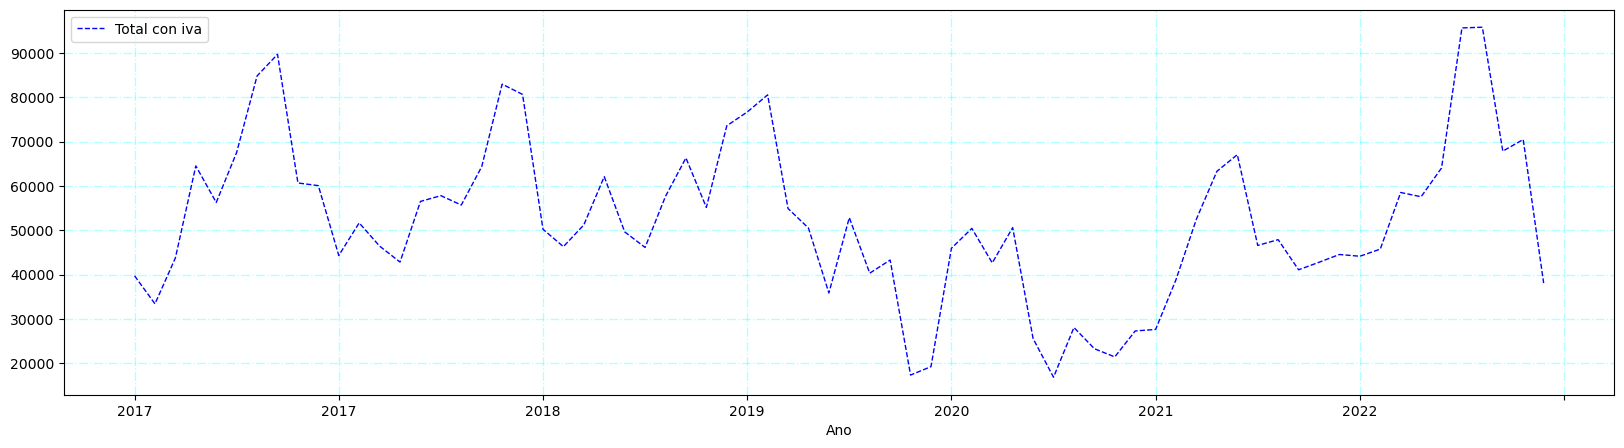

In [25]:
#Representamos la facturación total.
x = np.linspace(0, 5, 100)
ventas.plot(x="Ano", y=["Total con iva"],figsize=(20,5), color='Blue', linestyle='--', linewidth=1)
plt.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=1)
plt.show()

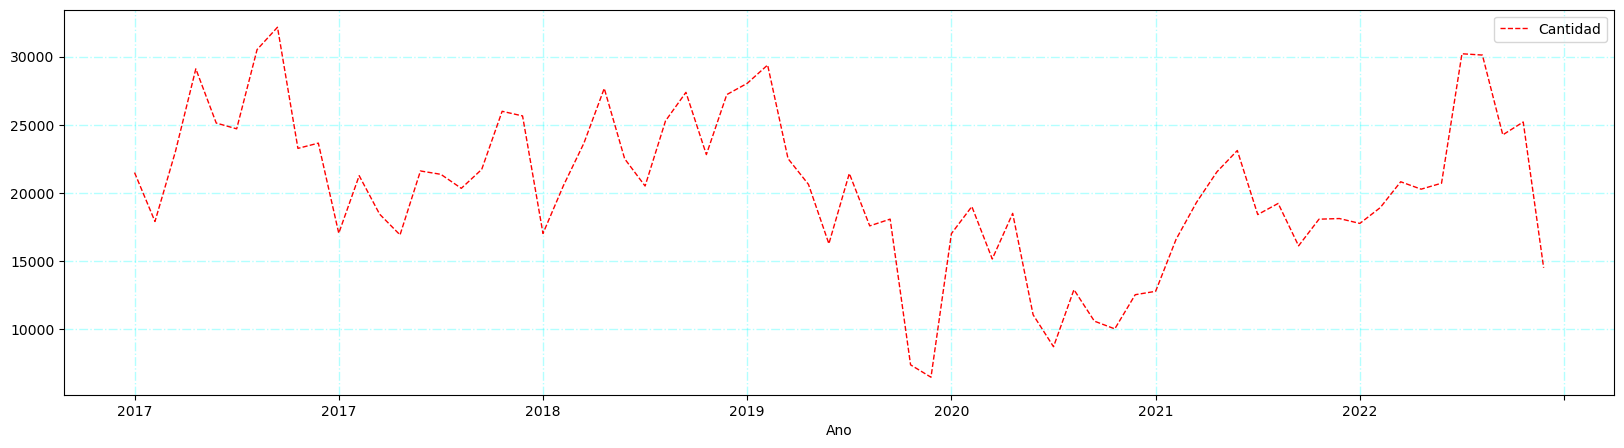

In [26]:

x = np.linspace(0, 5, 100)
ventas.plot(x="Ano", y=["Cantidad"],figsize=(20,5), color='Red', linestyle='--', linewidth=1)
plt.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=1)
plt.show()

In [27]:
df_ventasProductoAnos.groupby('Meses')['Total con iva','Cantidad'].agg(['sum'])

,Total con iva,Cantidad
,sum,sum
Meses,,
2016-12,27653.50,14476.0
2017-01,39729.25,21499.0
2017-02,33400.90,17914.0
2017-03,43757.45,23033.0
2017-04,64510.70,29104.0
...,...,...
2022-08,95795.95,30115.0
2022-09,67845.35,24265.0


In [28]:
ventas['Dia'] = pd.to_datetime(ventas['Dia'], format='%Y-%m-%d')
## Creamos un dataframe cuyo índice sea el campo fecha y que contenga nuestra variable Ventas
df_ventas_hist = pd.DataFrame(ventas['Total con iva'].tolist(),
                             index = ventas['Dia'].tolist(),
                             columns = ['Total con iva'])
df_ventas_hist

,Total con iva
2017-01-01,39729.25
2017-02-01,33400.90
2017-03-01,43757.45
2017-04-01,64510.70
2017-05-01,56264.85
...,...
2022-07-01,95638.90
2022-08-01,95795.95
2022-09-01,67845.35
2022-10-01,70464.30


In [29]:
## Necesitamos incluir 12 periodos más a nuestro dataframe, con la función date_range es muy fácil.
## Como es predicción anual, nuestra frecuencia será anual.
periodos = pd.date_range('2022-12-31', periods = 13, freq = 'M')
periodos

DatetimeIndex(['2022-12-31', '2023-01-31', '2023-02-28', '2023-03-31',
               '2023-04-30', '2023-05-31', '2023-06-30', '2023-07-31',
               '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30',
               '2023-12-31'],
              dtype='datetime64[ns]', freq='M')

In [30]:
## Creamos un dataframe con nuestras fechas a predecir
df_prediccion = pd.DataFrame({'Total con iva':[np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]},
                             index = periodos)
df_prediccion

,Total con iva
2022-12-31,NaN
2023-01-31,NaN
2023-02-28,NaN
2023-03-31,NaN
2023-04-30,NaN
2023-05-31,NaN
2023-06-30,NaN
2023-07-31,NaN
2023-08-31,NaN
2023-09-30,NaN


In [31]:
## Unimos el dataframe del histórico y el de la predicción
df_ventas_hist = pd.concat([df_ventas_hist, df_prediccion], ignore_index = False)

In [32]:
## Modificamos el formato de muestra del dataframe para que sea más fácil leerlo
pd.options.display.float_format = '{:,.1f}'.format
df_ventas_hist

,Total con iva
2017-01-01,"39,729.2"
2017-02-01,"33,400.9"
2017-03-01,"43,757.4"
2017-04-01,"64,510.7"
2017-05-01,"56,264.8"
...,...
2023-08-31,NaN
2023-09-30,NaN
2023-10-31,NaN
2023-11-30,NaN


In [33]:
## Crear dataframe
df_ventas_hist_2 = df_ventas_hist.copy(deep=True)

In [34]:
## Creamos un campo para nuestra previsión y lo rellenamos con Nan
df_ventas_hist['prevision_M1']=np.nan
## Igualamos los dos últimos años en los que vamos a hacer la previsión al valor del último año de histórico
df_ventas_hist['prevision_M1'][-14:]=df_ventas_hist['Total con iva'][-14]
df_ventas_hist.tail(15)

,Total con iva,prevision_M1
2022-10-01,"70,464.3",NaN
2022-11-01,"38,086.0","38,086.0"
2022-12-31,NaN,"38,086.0"
2023-01-31,NaN,"38,086.0"
2023-02-28,NaN,"38,086.0"
2023-03-31,NaN,"38,086.0"
2023-04-30,NaN,"38,086.0"
2023-05-31,NaN,"38,086.0"
2023-06-30,NaN,"38,086.0"
2023-07-31,NaN,"38,086.0"


<AxesSubplot: title={'center': '¿Cuál es nuestra previsión? \n'}>

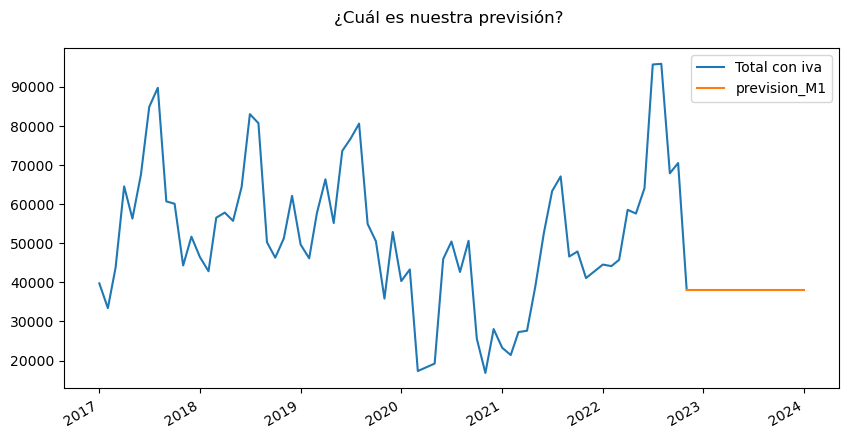

In [35]:
## Representamos nuestra previsión
df_ventas_hist.plot(figsize=(10,5),
                  title='¿Cuál es nuestra previsión? \n')

<AxesSubplot: title={'center': '¿Cuál es nuestra previsión? \n'}>

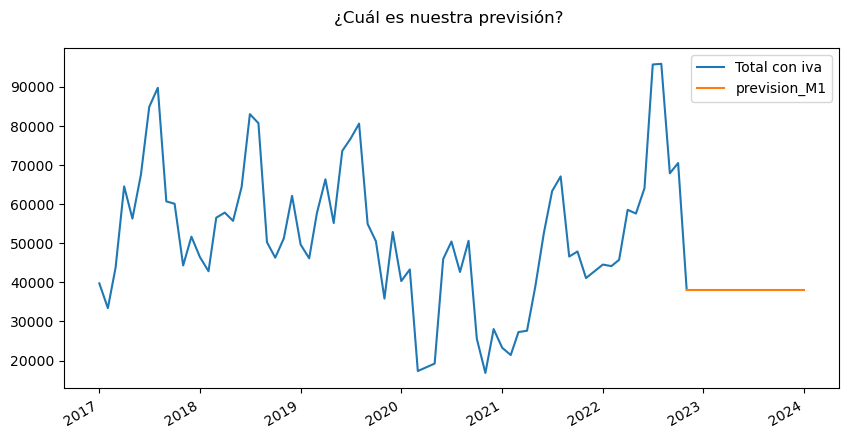

In [36]:
## Representamos nuestra previsión
df_ventas_hist.plot(figsize=(10,5),
                  title='¿Cuál es nuestra previsión? \n')

In [37]:
## Hacemos un desplazamiento de nuestra variable para calcular esa variación
df_ventas_hist['Total con iva_shift'] = df_ventas_hist['Total con iva'].shift(1)
df_ventas_hist['var AA'] = df_ventas_hist['Total con iva'] - df_ventas_hist['Total con iva_shift']
## Creamos un campo para nuestra previsión y lo rellenamos con Nan
df_ventas_hist['prevision_M2']=np.nan
## Igualamos el último valor al registro correspondiente de la nueva variable (para que se vea mejor la representación)
df_ventas_hist['prevision_M2'][-14] = df_ventas_hist['Total con iva'][-14]
df_ventas_hist.tail(16)

,Total con iva,prevision_M1,Total con iva_shift,var AA,prevision_M2
2022-09-01,"67,845.4",NaN,"95,795.9","-27,950.6",NaN
2022-10-01,"70,464.3",NaN,"67,845.4","2,618.9",NaN
2022-11-01,"38,086.0","38,086.0","70,464.3","-32,378.3","38,086.0"
2022-12-31,NaN,"38,086.0","38,086.0",NaN,NaN
2023-01-31,NaN,"38,086.0",NaN,NaN,NaN
2023-02-28,NaN,"38,086.0",NaN,NaN,NaN
2023-03-31,NaN,"38,086.0",NaN,NaN,NaN
2023-04-30,NaN,"38,086.0",NaN,NaN,NaN
2023-05-31,NaN,"38,086.0",NaN,NaN,NaN
2023-06-30,NaN,"38,086.0",NaN,NaN,NaN


In [38]:
## Rellenamos la variable con la variación, replicando el último valor hasta el final
## ffill: propagate last valid observation forward to next valid backfill
df_ventas_hist['var AA']=df_ventas_hist['var AA'].fillna(method='ffill')
## Sumamos el acumulado de esa variación a la previsión que tenemos del modelo 1
df_ventas_hist['prevision_M2'][-13:] = df_ventas_hist['var AA'][-13:].cumsum() + df_ventas_hist['prevision_M1'][-13:]
df_ventas_hist.tail(16)

,Total con iva,prevision_M1,Total con iva_shift,var AA,prevision_M2
2022-09-01,"67,845.4",NaN,"95,795.9","-27,950.6",NaN
2022-10-01,"70,464.3",NaN,"67,845.4","2,618.9",NaN
2022-11-01,"38,086.0","38,086.0","70,464.3","-32,378.3","38,086.0"
2022-12-31,NaN,"38,086.0","38,086.0","-32,378.3","5,707.7"
2023-01-31,NaN,"38,086.0",NaN,"-32,378.3","-26,670.6"
2023-02-28,NaN,"38,086.0",NaN,"-32,378.3","-59,048.9"
2023-03-31,NaN,"38,086.0",NaN,"-32,378.3","-91,427.2"
2023-04-30,NaN,"38,086.0",NaN,"-32,378.3","-123,805.5"
2023-05-31,NaN,"38,086.0",NaN,"-32,378.3","-156,183.8"
2023-06-30,NaN,"38,086.0",NaN,"-32,378.3","-188,562.1"


<AxesSubplot: title={'center': '¿Cuál es nuestra previsión? \n'}>

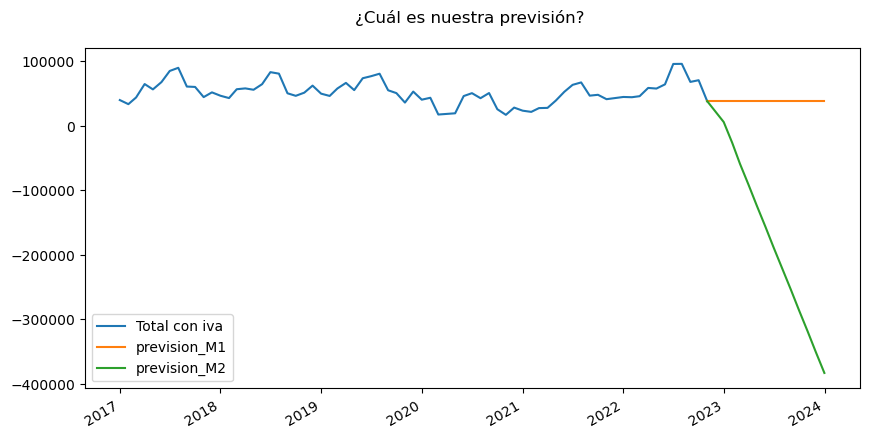

In [39]:
## Representamos nuestra previsión
df_ventas_hist.loc[:,['Total con iva','prevision_M1','prevision_M2']].plot(figsize=(10,5),
                  title='¿Cuál es nuestra previsión? \n')

In [40]:
## Creamos un campo para nuestra previsión y lo rellenamos con Nan
df_ventas_hist['prevision_M3'] = np.nan
## Igualamos el último valor al registro correspondiente de la nueva variable (para que se vea mejor la representación)
df_ventas_hist['prevision_M3'][-14] = df_ventas_hist['Total con iva'][-14]
## Igualamos los dos últimos años en los que vamos a hacer la previsión con la media de todos los alquileres
df_ventas_hist['prevision_M3'][-13:] = df_ventas_hist['Total con iva'].mean()
df_ventas_hist.tail(16)

,Total con iva,prevision_M1,Total con iva_shift,var AA,prevision_M2,prevision_M3
2022-09-01,"67,845.4",NaN,"95,795.9","-27,950.6",NaN,NaN
2022-10-01,"70,464.3",NaN,"67,845.4","2,618.9",NaN,NaN
2022-11-01,"38,086.0","38,086.0","70,464.3","-32,378.3","38,086.0","38,086.0"
2022-12-31,NaN,"38,086.0","38,086.0","-32,378.3","5,707.7","52,220.6"
2023-01-31,NaN,"38,086.0",NaN,"-32,378.3","-26,670.6","52,220.6"
2023-02-28,NaN,"38,086.0",NaN,"-32,378.3","-59,048.9","52,220.6"
2023-03-31,NaN,"38,086.0",NaN,"-32,378.3","-91,427.2","52,220.6"
2023-04-30,NaN,"38,086.0",NaN,"-32,378.3","-123,805.5","52,220.6"
2023-05-31,NaN,"38,086.0",NaN,"-32,378.3","-156,183.8","52,220.6"
2023-06-30,NaN,"38,086.0",NaN,"-32,378.3","-188,562.1","52,220.6"


<AxesSubplot: title={'center': '¿Cuál es nuestra previsión? \n'}>

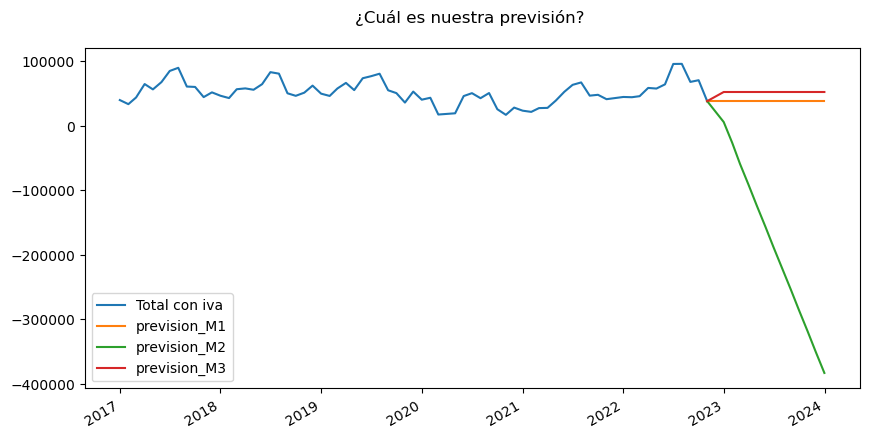

In [41]:
## Representamos nuestra previsión
df_ventas_hist.loc[:,['Total con iva','prevision_M1','prevision_M2','prevision_M3']].plot(figsize=(10,5),
                  title='¿Cuál es nuestra previsión? \n')

In [42]:
## Eliminamos la estacionalidad de la serie
df_ventas_hist['Total con iva_mm4'] = df_ventas_hist['Total con iva'].rolling(4).mean()

<AxesSubplot: >

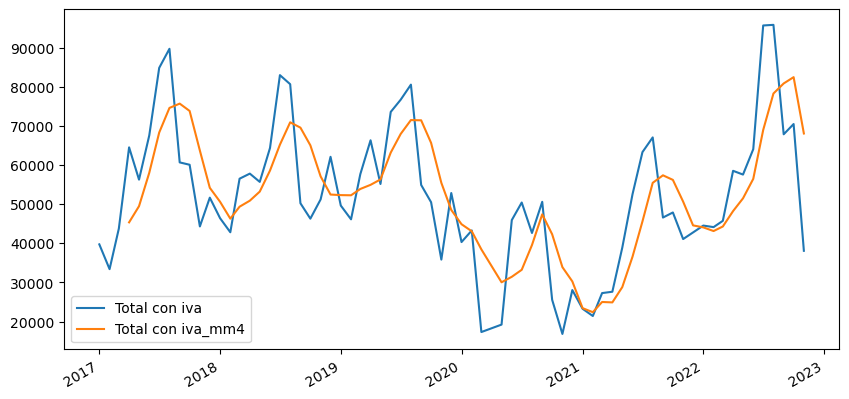

In [43]:
## Representamos el resultado
df_ventas_hist.loc[:,['Total con iva','Total con iva_mm4']].plot(figsize=(10,5))

In [44]:
## Eliminamos la tendencia
df_ventas_hist['Total con iva_sin_tend'] = df_ventas_hist['Total con iva'] - df_ventas_hist['Total con iva'].shift(1)
df_ventas_hist

,Total con iva,prevision_M1,Total con iva_shift,var AA,prevision_M2,prevision_M3,Total con iva_mm4,Total con iva_sin_tend
2017-01-01,"39,729.2",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-01,"33,400.9",NaN,"39,729.2","-6,328.3",NaN,NaN,NaN,"-6,328.3"
2017-03-01,"43,757.4",NaN,"33,400.9","10,356.5",NaN,NaN,NaN,"10,356.5"
2017-04-01,"64,510.7",NaN,"43,757.4","20,753.2",NaN,NaN,"45,349.6","20,753.2"
2017-05-01,"56,264.8",NaN,"64,510.7","-8,245.8",NaN,NaN,"49,483.5","-8,245.8"
...,...,...,...,...,...,...,...,...
2023-08-31,NaN,"38,086.0",NaN,"-32,378.3","-253,318.7","52,220.6",NaN,NaN
2023-09-30,NaN,"38,086.0",NaN,"-32,378.3","-285,697.0","52,220.6",NaN,NaN
2023-10-31,NaN,"38,086.0",NaN,"-32,378.3","-318,075.3","52,220.6",NaN,NaN
2023-11-30,NaN,"38,086.0",NaN,"-32,378.3","-350,453.6","52,220.6",NaN,NaN


<AxesSubplot: title={'center': '¿Cuál es nuestra componente aleatoria? \n'}>

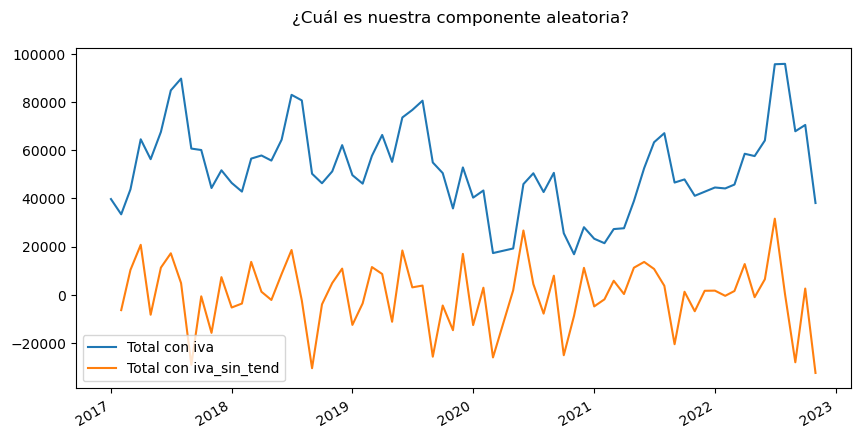

In [45]:
## Representamos nuestra serie
df_ventas_hist.loc[:,['Total con iva','Total con iva_sin_tend']].plot(figsize=(10,5),
                  title='¿Cuál es nuestra componente aleatoria? \n')

array([<AxesSubplot: title={'center': '¿Cómo evoluciona el alquiler de bicicletas?'}>,
       <AxesSubplot: title={'center': 'Serie sin estacionalidad'}>,
       <AxesSubplot: title={'center': 'Componente aleatoria'}>],
      dtype=object)

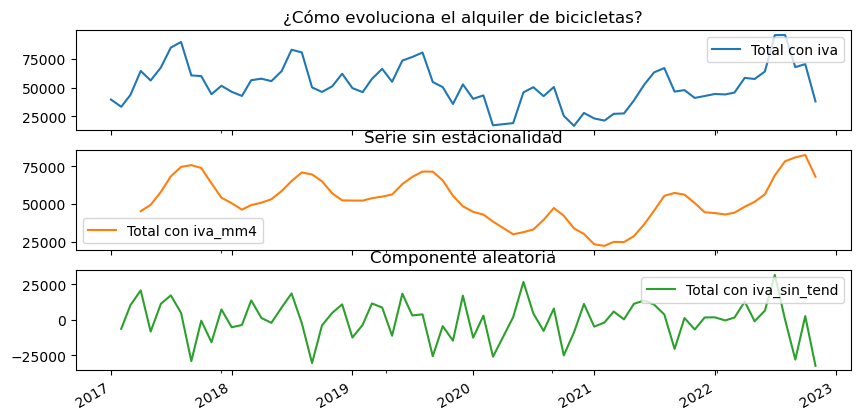

In [46]:
## Representamos el resultado
df_ventas_hist.loc[:,['Total con iva','Total con iva_mm4','Total con iva_sin_tend']].plot(figsize=(10,5),
                                                         subplots=True,
                                                         title= ['¿Cómo evoluciona el alquiler de bicicletas?',
                                                                'Serie sin estacionalidad',
                                                                'Componente aleatoria'])

array([<AxesSubplot: title={'center': '¿Cómo evoluciona las ventas?'}>,
       <AxesSubplot: title={'center': '¿Cuál es nuestra componente aleatoria?'}>],
      dtype=object)

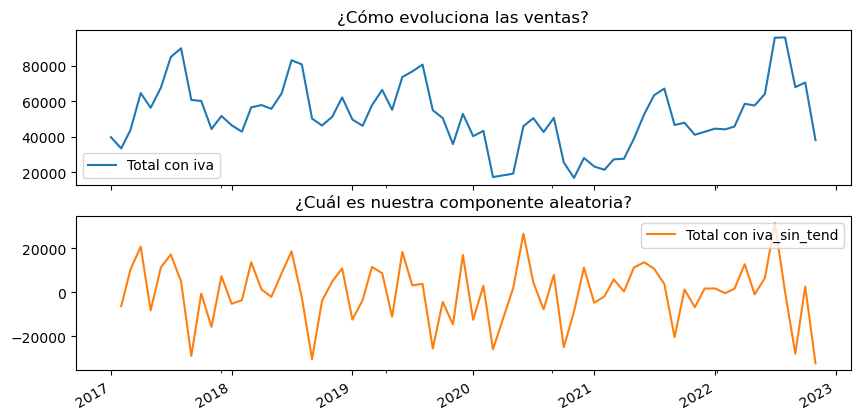

In [47]:
## Si la representamos en dos gráficos independientes, para que no nos engañen los rangos de las magnitudes
df_ventas_hist.loc[:,['Total con iva','Total con iva_sin_tend']].plot(figsize = (10,5),
                                                 subplots = True,
                                                 title = ['¿Cómo evoluciona las ventas?',
                                                          '¿Cuál es nuestra componente aleatoria?'])

In [48]:
## Creamos un campo para nuestra previsión y lo rellenamos con Nan
df_ventas_hist['prevision_M3_st']=np.nan
## Incluimos como previsión de los dos últimos meses la media de todos los alquileres
df_ventas_hist['prevision_M3_st'][-14:]=df_ventas_hist['Total con iva_sin_tend'].mean()
df_ventas_hist

,Total con iva,prevision_M1,Total con iva_shift,var AA,prevision_M2,prevision_M3,Total con iva_mm4,Total con iva_sin_tend,prevision_M3_st
2017-01-01,"39,729.2",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-01,"33,400.9",NaN,"39,729.2","-6,328.3",NaN,NaN,NaN,"-6,328.3",NaN
2017-03-01,"43,757.4",NaN,"33,400.9","10,356.5",NaN,NaN,NaN,"10,356.5",NaN
2017-04-01,"64,510.7",NaN,"43,757.4","20,753.2",NaN,NaN,"45,349.6","20,753.2",NaN
2017-05-01,"56,264.8",NaN,"64,510.7","-8,245.8",NaN,NaN,"49,483.5","-8,245.8",NaN
...,...,...,...,...,...,...,...,...,...
2023-08-31,NaN,"38,086.0",NaN,"-32,378.3","-253,318.7","52,220.6",NaN,NaN,-23.8
2023-09-30,NaN,"38,086.0",NaN,"-32,378.3","-285,697.0","52,220.6",NaN,NaN,-23.8
2023-10-31,NaN,"38,086.0",NaN,"-32,378.3","-318,075.3","52,220.6",NaN,NaN,-23.8
2023-11-30,NaN,"38,086.0",NaN,"-32,378.3","-350,453.6","52,220.6",NaN,NaN,-23.8


<AxesSubplot: title={'center': '¿Cuál es nuestra previsión sobre la componente aleatoria? \n'}>

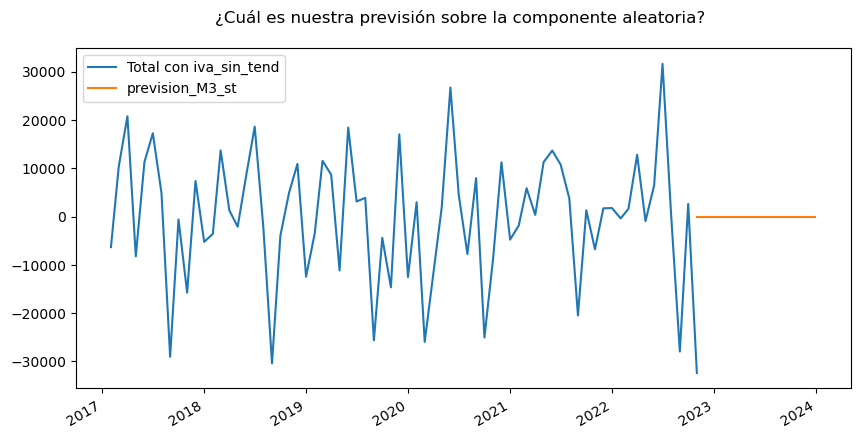

In [49]:
## Representamos nuestra previsión
df_ventas_hist.loc[:,['Total con iva_sin_tend','prevision_M3_st']].plot(figsize=(10,5),
                                                title='¿Cuál es nuestra previsión sobre la componente aleatoria? \n')

In [50]:
## Creamos un campo para nuestra previsión y lo rellenamos con Nan
df_ventas_hist['prevision_M3_ct'] = np.nan
## Sumamos el acumulado de la previsión a nuestra serie con tendencia
df_ventas_hist['prevision_M3_ct'][-14] = df_ventas_hist['Total con iva'][-14]
df_ventas_hist['prevision_M3_ct'][-13:] = df_ventas_hist['prevision_M3_st'][-13:].cumsum()\
                                      + df_ventas_hist['prevision_M1'][-13:]
df_ventas_hist

,Total con iva,prevision_M1,Total con iva_shift,var AA,prevision_M2,prevision_M3,Total con iva_mm4,Total con iva_sin_tend,prevision_M3_st,prevision_M3_ct
2017-01-01,"39,729.2",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-01,"33,400.9",NaN,"39,729.2","-6,328.3",NaN,NaN,NaN,"-6,328.3",NaN,NaN
2017-03-01,"43,757.4",NaN,"33,400.9","10,356.5",NaN,NaN,NaN,"10,356.5",NaN,NaN
2017-04-01,"64,510.7",NaN,"43,757.4","20,753.2",NaN,NaN,"45,349.6","20,753.2",NaN,NaN
2017-05-01,"56,264.8",NaN,"64,510.7","-8,245.8",NaN,NaN,"49,483.5","-8,245.8",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-08-31,NaN,"38,086.0",NaN,"-32,378.3","-253,318.7","52,220.6",NaN,NaN,-23.8,"37,871.7"
2023-09-30,NaN,"38,086.0",NaN,"-32,378.3","-285,697.0","52,220.6",NaN,NaN,-23.8,"37,847.8"
2023-10-31,NaN,"38,086.0",NaN,"-32,378.3","-318,075.3","52,220.6",NaN,NaN,-23.8,"37,824.0"
2023-11-30,NaN,"38,086.0",NaN,"-32,378.3","-350,453.6","52,220.6",NaN,NaN,-23.8,"37,800.2"


<AxesSubplot: title={'center': '¿Cuál es nuestra previsión final? \n'}>

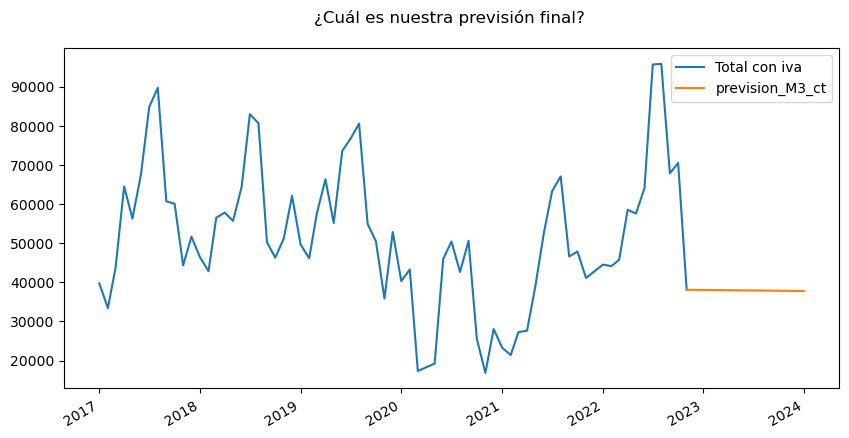

In [51]:
## Representamos nuestra previsión
df_ventas_hist.loc[:,['Total con iva','prevision_M3_ct']].plot(figsize=(10,5),
                                                     title='¿Cuál es nuestra previsión final? \n')

## Afinamos la previsión con un método algo más preciso

In [52]:
# Eliminamos la estacionalidad
df_ventas_hist_2['Total con iva_mm'] = df_ventas_hist_2['Total con iva'].rolling(12).mean()

In [53]:
df_ventas_hist_2.tail(14)

,Total con iva,Total con iva_mm
2022-11-01,"38,086.0","60,427.2"
2022-12-31,NaN,NaN
2023-01-31,NaN,NaN
2023-02-28,NaN,NaN
2023-03-31,NaN,NaN
2023-04-30,NaN,NaN
2023-05-31,NaN,NaN
2023-06-30,NaN,NaN
2023-07-31,NaN,NaN
2023-08-31,NaN,NaN


<AxesSubplot: title={'center': '¿Cómo evoluciona la facturación mensual sín estacionalidad? \n'}>

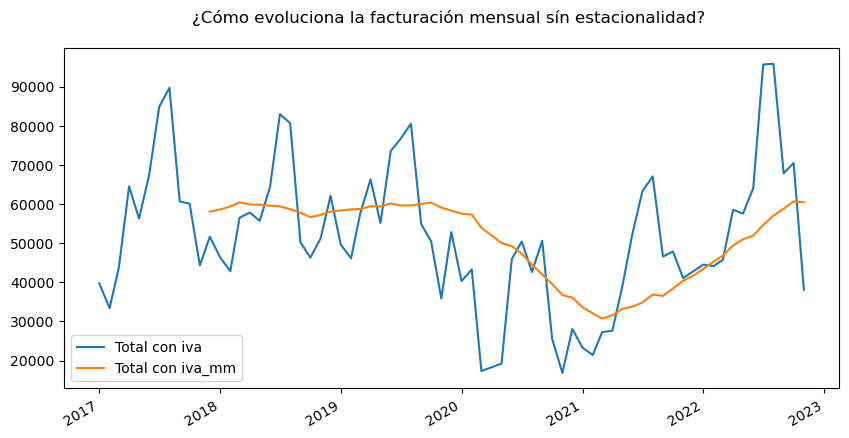

In [54]:
## Representamos el resultado
df_ventas_hist_2.loc[:,['Total con iva','Total con iva_mm']].plot(figsize=(10,5),
                  title='¿Cómo evoluciona la facturación mensual sín estacionalidad? \n')

In [55]:
# Eliminamos tendencia
df_ventas_hist_2['Total con iva_sin_tend'] = df_ventas_hist_2['Total con iva_mm'] - df_ventas_hist_2['Total con iva_mm'].shift(1)
df_ventas_hist_2.tail(14)

,Total con iva,Total con iva_mm,Total con iva_sin_tend
2022-11-01,"38,086.0","60,427.2",-249.8
2022-12-31,NaN,NaN,NaN
2023-01-31,NaN,NaN,NaN
2023-02-28,NaN,NaN,NaN
2023-03-31,NaN,NaN,NaN
2023-04-30,NaN,NaN,NaN
2023-05-31,NaN,NaN,NaN
2023-06-30,NaN,NaN,NaN
2023-07-31,NaN,NaN,NaN
2023-08-31,NaN,NaN,NaN


<AxesSubplot: >

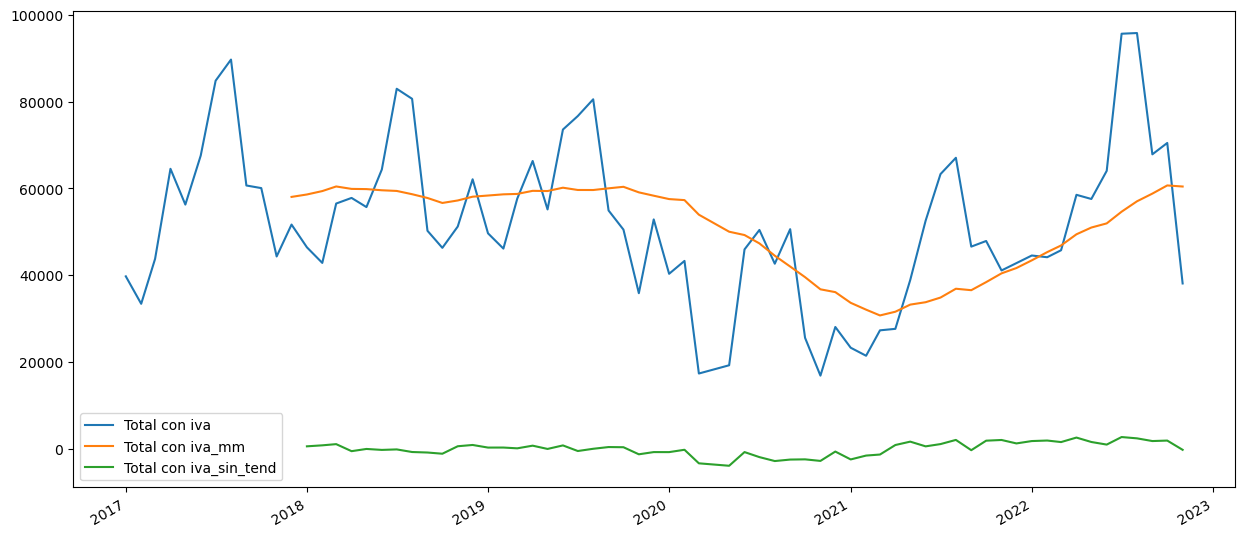

In [56]:
## Representamos el resultado
df_ventas_hist_2.loc[:,['Total con iva','Total con iva_mm','Total con iva_sin_tend']].plot(figsize=(15,7))

array([<AxesSubplot: title={'center': '¿Cómo evoluciona la facturación?'}>,
       <AxesSubplot: title={'center': 'Sín estacionalidad'}>,
       <AxesSubplot: title={'center': 'Sín tendencia'}>], dtype=object)

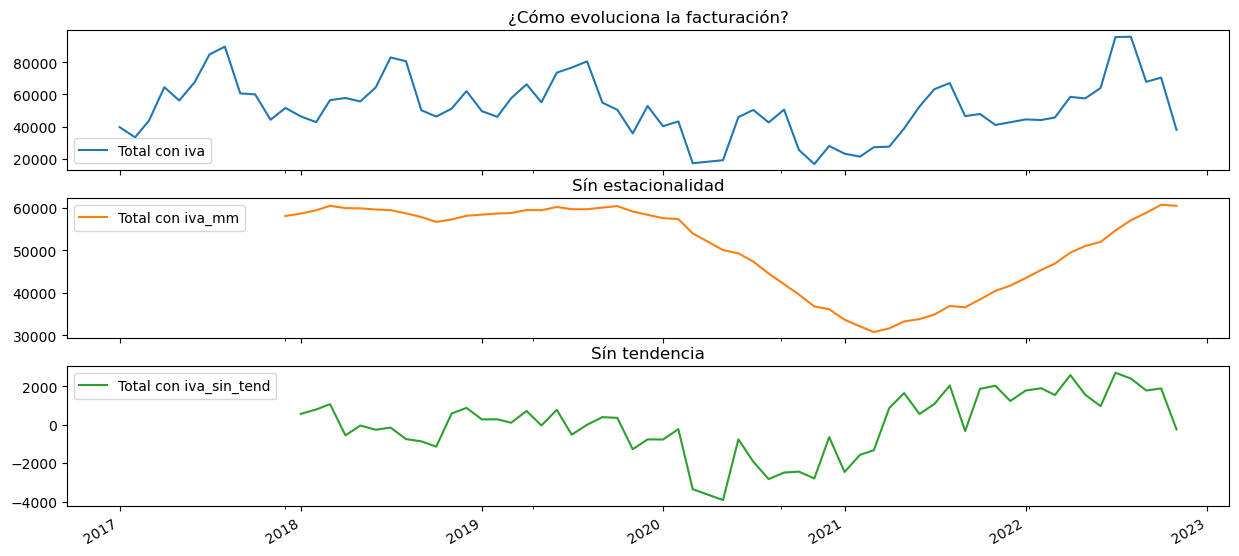

In [57]:
## Representación por separado
df_ventas_hist_2.loc[:,['Total con iva','Total con iva_mm','Total con iva_sin_tend']].plot(figsize=(15,7),
                                                       subplots=True,
                                                       title=['¿Cómo evoluciona la facturación?',
                                                             'Sín estacionalidad',
                                                             'Sín tendencia'])

In [58]:
## Creamos un campo para nuestra previsión y lo rellenamos con Nan
df_ventas_hist_2['prevision'] = np.nan
df_ventas_hist_2['prevision'][-13:] = df_ventas_hist_2['Total con iva_sin_tend'].mean()

In [59]:
df_ventas_hist_2.tail(14)

,Total con iva,Total con iva_mm,Total con iva_sin_tend,prevision
2022-11-01,"38,086.0","60,427.2",-249.8,NaN
2022-12-31,NaN,NaN,NaN,41.3
2023-01-31,NaN,NaN,NaN,41.3
2023-02-28,NaN,NaN,NaN,41.3
2023-03-31,NaN,NaN,NaN,41.3
2023-04-30,NaN,NaN,NaN,41.3
2023-05-31,NaN,NaN,NaN,41.3
2023-06-30,NaN,NaN,NaN,41.3
2023-07-31,NaN,NaN,NaN,41.3
2023-08-31,NaN,NaN,NaN,41.3


<AxesSubplot: >

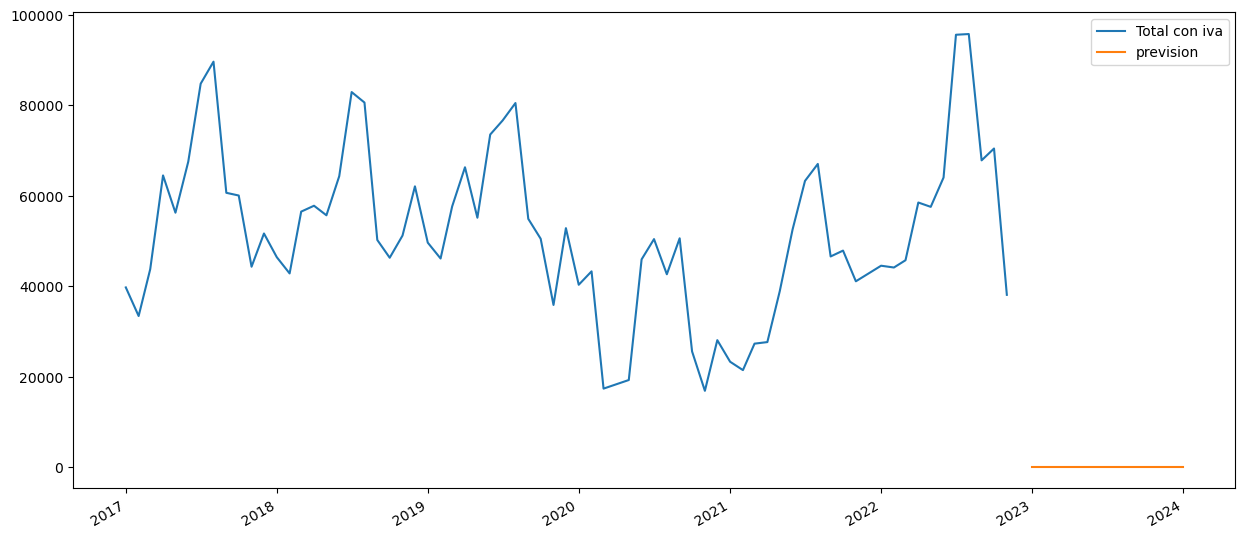

In [60]:
# Representación
df_ventas_hist_2.loc[:,['Total con iva','prevision']].plot(figsize=(15,7))

In [61]:
# Incorporamos la tendencia
df_ventas_hist_2['prevision_t'] = np.nan
df_ventas_hist_2['prevision_t'][-14:] = df_ventas_hist_2['Total con iva_mm'][-14:]
df_ventas_hist_2['prevision_t'][-13:] = df_ventas_hist_2['prevision'][-13:].cumsum()\
                                            + df_ventas_hist_2['Total con iva_mm'][-14]
df_ventas_hist_2.tail(14)

,Total con iva,Total con iva_mm,Total con iva_sin_tend,prevision,prevision_t
2022-11-01,"38,086.0","60,427.2",-249.8,NaN,"60,427.2"
2022-12-31,NaN,NaN,NaN,41.3,"60,468.5"
2023-01-31,NaN,NaN,NaN,41.3,"60,509.7"
2023-02-28,NaN,NaN,NaN,41.3,"60,551.0"
2023-03-31,NaN,NaN,NaN,41.3,"60,592.2"
2023-04-30,NaN,NaN,NaN,41.3,"60,633.5"
2023-05-31,NaN,NaN,NaN,41.3,"60,674.7"
2023-06-30,NaN,NaN,NaN,41.3,"60,716.0"
2023-07-31,NaN,NaN,NaN,41.3,"60,757.2"
2023-08-31,NaN,NaN,NaN,41.3,"60,798.5"


<AxesSubplot: >

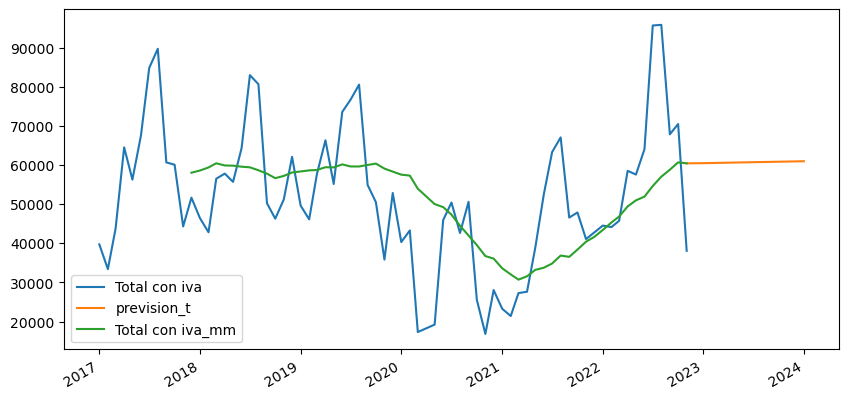

In [62]:
## Representamos nuestra previsión
df_ventas_hist_2.loc[:,['Total con iva','prevision_t','Total con iva_mm']].plot(figsize=(10,5))

In [63]:
## Calculamos los coeficientes de estacionalidad
df_ventas_hist_2['coef_estac'] = df_ventas_hist_2['Total con iva'] / df_ventas_hist_2['Total con iva_mm']

In [64]:
## Aplicamos los coeficientes de estacionalidad sobre nuestra previsión con tendencia
## Como queremos la previsión para 4 trimestres, desplazamos esos coeficientes y los multiplicamos por 
## el valor de la previsión con tendencia
df_ventas_hist_2['prev_t_ce'] = np.nan
df_ventas_hist_2['prev_t_ce'][-14] = df_ventas_hist_2['Total con iva'][-14]
df_ventas_hist_2['prev_t_ce'] = df_ventas_hist_2['prevision_t'] \
                                        * df_ventas_hist_2['coef_estac'].shift(13)
df_ventas_hist_2['prev_t_ce'][-14] = df_ventas_hist_2['Total con iva'][-14]

In [65]:
df_ventas_hist_2.tail(16)

,Total con iva,Total con iva_mm,Total con iva_sin_tend,prevision,prevision_t,coef_estac,prev_t_ce
2022-09-01,"67,845.4","58,794.6","1,772.2",NaN,NaN,1.2,NaN
2022-10-01,"70,464.3","60,677.0","1,882.4",NaN,NaN,1.2,NaN
2022-11-01,"38,086.0","60,427.2",-249.8,NaN,"60,427.2",0.6,"38,086.0"
2022-12-31,NaN,NaN,NaN,41.3,"60,468.5",NaN,"61,466.4"
2023-01-31,NaN,NaN,NaN,41.3,"60,509.7",NaN,"62,157.4"
2023-02-28,NaN,NaN,NaN,41.3,"60,551.0",NaN,"62,107.9"
2023-03-31,NaN,NaN,NaN,41.3,"60,592.2",NaN,"59,024.6"
2023-04-30,NaN,NaN,NaN,41.3,"60,633.5",NaN,"59,205.8"
2023-05-31,NaN,NaN,NaN,41.3,"60,674.7",NaN,"71,844.7"
2023-06-30,NaN,NaN,NaN,41.3,"60,716.0",NaN,"68,556.3"


<AxesSubplot: >

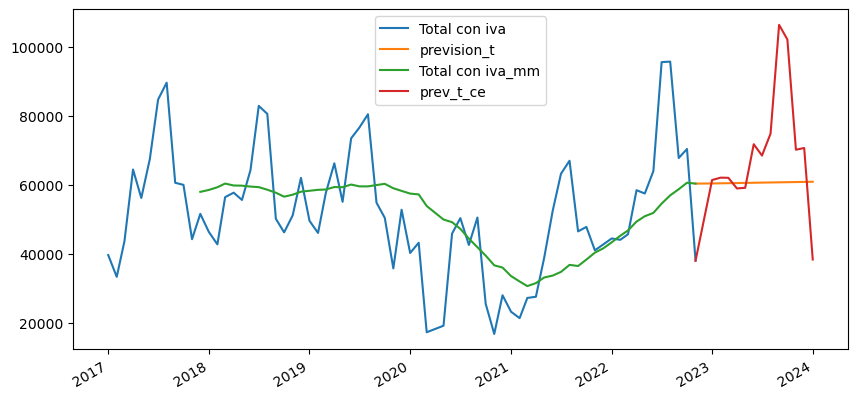

In [66]:
## Representamos nuestra previsión final
df_ventas_hist_2.loc[:,['Total con iva','prevision_t', 'Total con iva_mm', 'prev_t_ce']].plot(figsize=(10,5))


# Librería Prophet

In [67]:
df_prophet = ventas.drop(['Ano', 'Meses', 'Cantidad', 'Total sin iva'], axis=1)
df_prophet

,Dia,Total con iva
1,2017-01-01,"39,729.2"
2,2017-02-01,"33,400.9"
3,2017-03-01,"43,757.4"
4,2017-04-01,"64,510.7"
5,2017-05-01,"56,264.8"
...,...,...
66,2022-07-01,"95,638.9"
67,2022-08-01,"95,795.9"
68,2022-09-01,"67,845.4"
69,2022-10-01,"70,464.3"


In [68]:
#Preprocesamos los datos para que prophet pueda leerlos correctamente y aplicar su previsión
df_prophet= df_prophet.rename(columns={'Dia': 'ds', 'Total con iva': 'y'})

In [69]:
df_prophet.tail()

,ds,y
66,2022-07-01,"95,638.9"
67,2022-08-01,"95,795.9"
68,2022-09-01,"67,845.4"
69,2022-10-01,"70,464.3"
70,2022-11-01,"38,086.0"


In [70]:
df_prophet['y'] = np.log(df_prophet['y'])

In [71]:
df_prophet.head()

,ds,y
1,2017-01-01,10.6
2,2017-02-01,10.4
3,2017-03-01,10.7
4,2017-04-01,11.1
5,2017-05-01,10.9


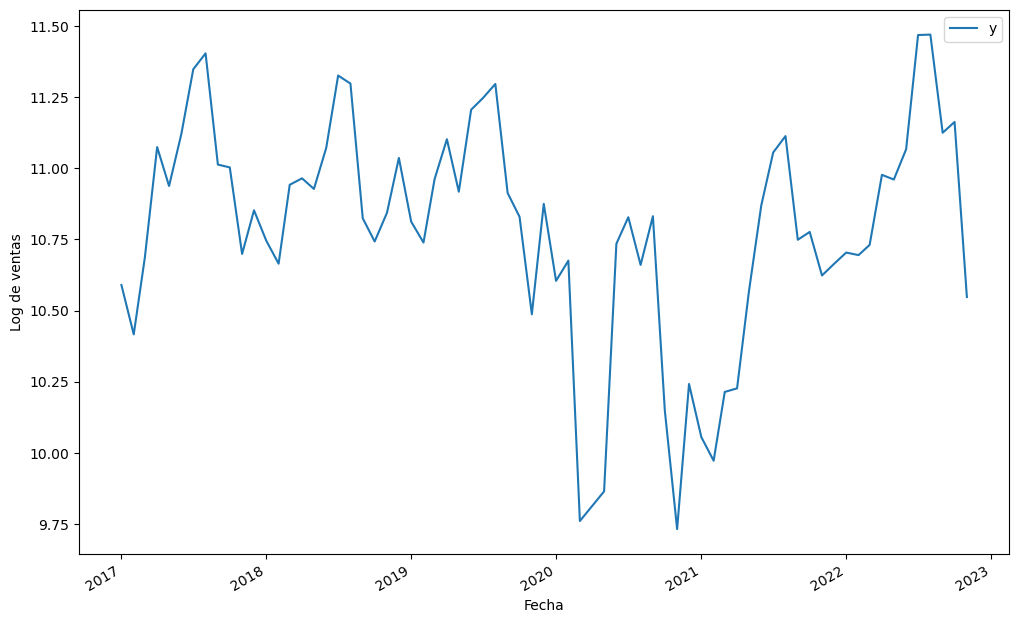

In [72]:
## Representamos nuestra serie
ax = df_prophet[:365].set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Log de ventas')
ax.set_xlabel('Fecha')
plt.show()

In [73]:
#Proponemos un módelo
modelo = Prophet(seasonality_mode='multiplicative')

In [74]:
modelo.fit(df_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -78.5435
Iteration  1. Log joint probability =    110.573. Improved by 189.117.
Iteration  2. Log joint probability =     171.66. Improved by 61.0867.
Iteration  3. Log joint probability =    206.239. Improved by 34.5789.
Iteration  4. Log joint probability =    226.234. Improved by 19.9955.
Iteration  5. Log joint probability =    227.008. Improved by 0.774076.
Iteration  6. Log joint probability =    229.194. Improved by 2.18567.
Iteration  7. Log joint probability =    230.565. Improved by 1.37119.
Iteration  8. Log joint probability =     231.25. Improved by 0.685074.
Iteration  9. Log joint probability =    231.405. Improved by 0.154333.
Iteration 10. Log joint probability =    232.058. Improved by 0.653773.
Iteration 11. Log joint probability =    233.034. Improved by 0.975951.
Iteration 12. Log joint probability =    233.246. Improved by 0.211985.
Iteration 13. Log joint probability =    233.601. Improved by 0.354851.
Iteration 14. Log joint proba

In [75]:
futuro = modelo.make_future_dataframe(periods=425)

In [76]:
prevision = modelo.predict(futuro)

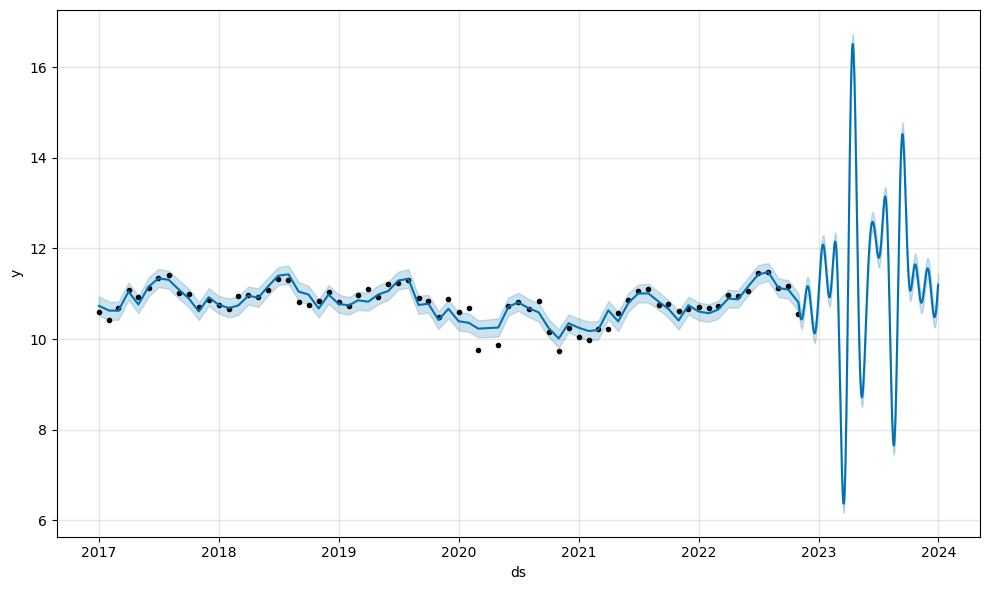

In [77]:
#Representamos la primera previsión
modelo.plot(prevision);

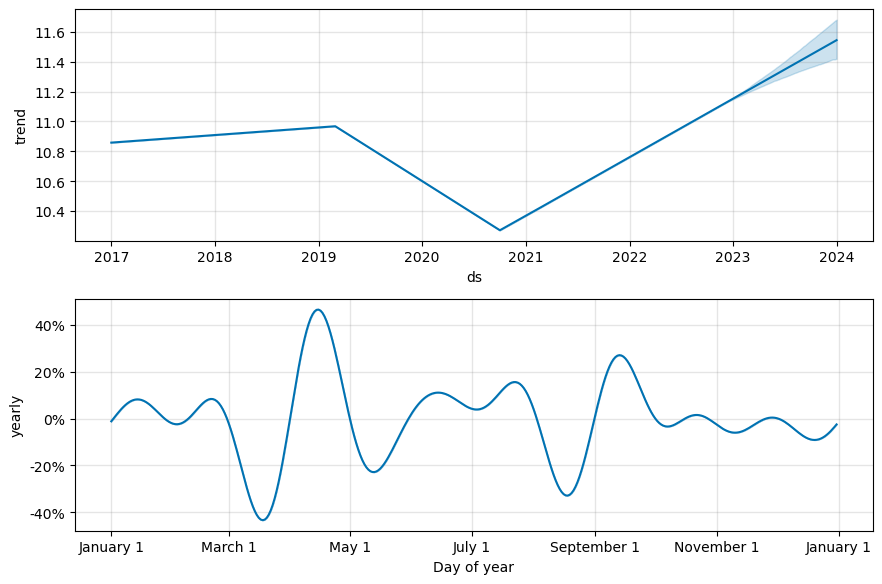

In [78]:
modelo.plot_components(prevision, weekly_start = 1);

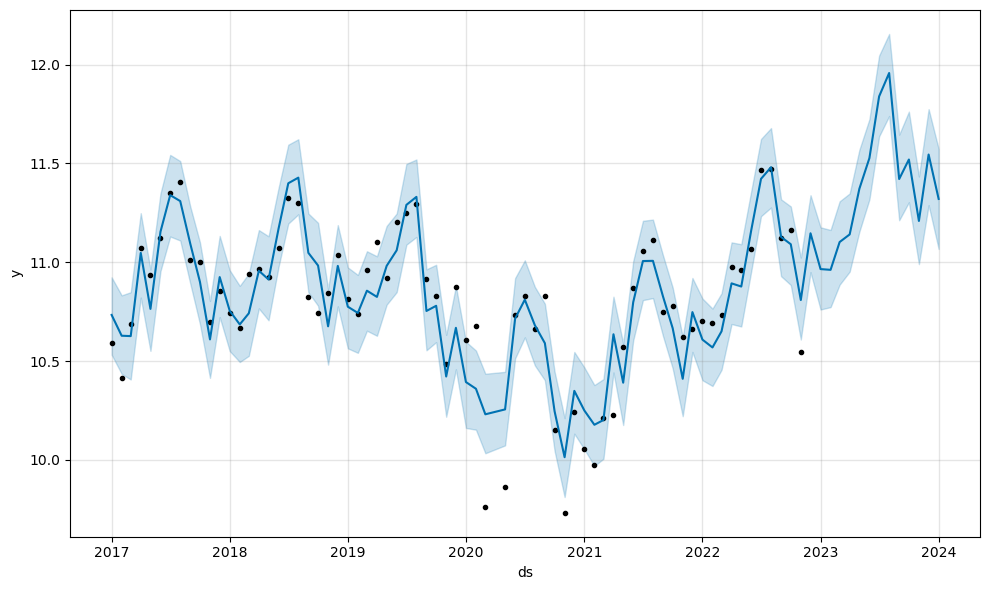

In [79]:
#Crearemos otra variable indicando que la estacionalidad es mensual, y vemos que el resultado mejora bastante.
#Nos quedaremos con éste módelo de previsión.
futuro2 = modelo.make_future_dataframe(periods = 14, freq = 'MS')
prevision2 = modelo.predict(futuro2)
modelo.plot(prevision2);

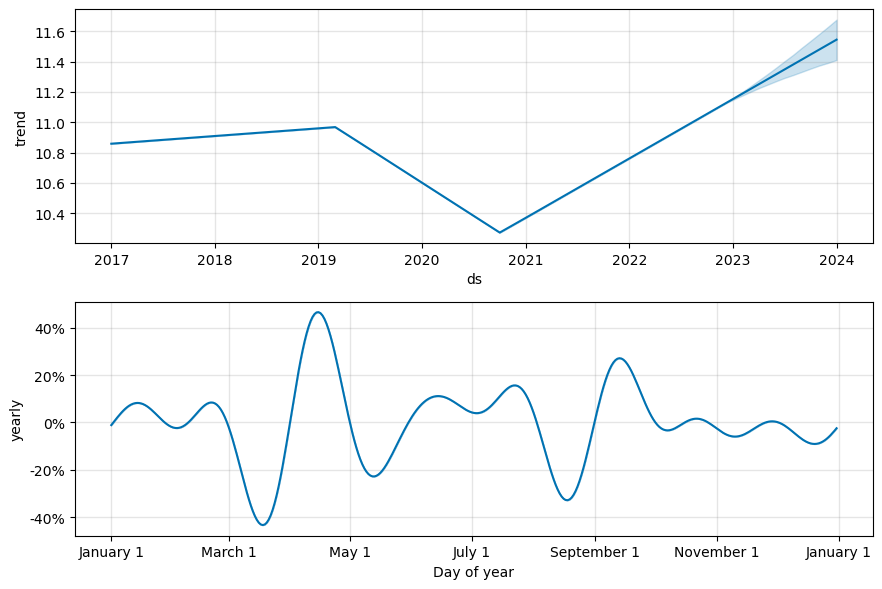

In [80]:
modelo.plot_components(prevision2, weekly_start = 1);

In [81]:
# Vamos a añadir las listas de holidays, para que el modelo pueda aprender las fechas extraordinarias, empezaremos por poner hasta dónde nuestros datos reales llegan.
semana_santa = pd.DataFrame({
    'holiday': 'semana_santa',
    'ds': pd.to_datetime([
                        '2017-04-9','2017-04-10','2017-04-11','2017-04-12','2017-04-13','2017-04-14','2017-04-15','2017-04-16',
                        '2018-03-25','2018-03-26','2018-03-27','2018-03-28','2018-03-29','2018-03-30','2018-03-31','2018-04-1',
                        '2019-04-14','2019-04-15','2019-04-16','2019-04-17','2019-04-18','2019-04-19','2019-04-20','2019-04-21',
                        '2020-04-5','2020-04-6','2020-04-7','2020-04-8','2020-04-9','2020-04-10','2020-04-11','2020-04-12',                                                    
                        '2021-03-28','2021-03-29','2021-03-30','2021-03-31','2021-04-1','2021-04-2','2021-04-3','2021-04-4',                                                   
                        '2022-04-10','2022-04-11','2022-04-12','2022-04-13','2022-04-14','2022-04-15','2022-04-16','2022-04-17']),
    'lower_window': 0,
    'upper_window': 0,
})

In [82]:
navidad = pd.DataFrame({
    'holiday': 'navidad',
    'ds': pd.to_datetime([
                        '2016-12-24','2016-12-25','2016-12-26',
                        '2017-12-24','2017-12-25','2017-12-26',
                        '2018-12-24','2018-12-25','2018-12-26',
                        '2018-12-24','2018-12-25','2018-12-26',
                        '2019-12-24','2019-12-25','2019-12-26',
                        '2020-12-24','2020-12-25','2020-12-26',
                        '2021-12-24','2021-12-25','2021-12-26',]),
    'lower_window': 0,
    'upper_window': 4,
})

In [83]:
fin_de_año = pd.DataFrame({
    'holiday': 'fin de año',
    'ds': pd.to_datetime([
                        '2016-12-31',
                        '2017-12-31',
                        '2019-12-31',
                        '2020-12-31',
                        '2021-12-31']),
    'lower_window': 0,
    'upper_window': 1,
})

In [84]:
noche_de_reyes = pd.DataFrame({
    'holiday': 'noche de reyes',
    'ds': pd.to_datetime([
                        '2017-1-05',
                        '2018-1-05',
                        '2019-1-05',
                        '2020-1-05',
                        '2021-1-05',
                        '2022-1-05']),
    'lower_window': 0,
    'upper_window': 1,
})

In [85]:
carnaval = pd.DataFrame({
    'holiday': 'carnaval',
    'ds': pd.to_datetime([
                        '2017-2-25',
                        '2018-2-10',
                        '2019-3-2',
                        '2020-2-18',
                        '2021-2-13',
                        '2022-2-26']),
    'lower_window': 0,
    'upper_window': 0,
})

In [86]:
dia_del_trabajador = pd.DataFrame({
    'holiday': 'dia_del_trabajador',
    'ds': pd.to_datetime([
                        '2017-5-1',
                        '2018-5-1',
                        '2019-5-1',
                        '2020-5-1',
                        '2021-5-1',
                        '2022-5-1']),
    'lower_window': 0,
    'upper_window': 0,
})

In [87]:
san_juan = pd.DataFrame({
    'holiday': 'san_juan',
    'ds': pd.to_datetime([
                        '2017-6-23',
                        '2018-6-23',
                        '2019-6-23',
                        '2020-6-23',
                        '2021-6-23',
                        '2022-6-23']),
    'lower_window': 0,
    'upper_window': 1,
})

In [88]:
san_pedro = pd.DataFrame({
    'holiday': 'san_pedro',
    'ds': pd.to_datetime([
                        '2017-6-29',
                        '2018-6-29',
                        '2019-6-29',
                        '2020-6-29',
                        '2021-6-29',
                        '2022-6-29']),
    'lower_window': 0,
    'upper_window': 0,
})

In [89]:
san_zenon = pd.DataFrame({
    'holiday': 'san_zenon',
    'ds': pd.to_datetime([
                        '2017-7-7','2017-7-8','2017-7-9','2017-7-10',
                        '2018-7-6','2018-7-7','2017-7-8','2017-7-9',
                        '2019-7-5','2019-7-6','2019-7-7','2019-7-8','2019-7-9',
                        '2020-7-8','2020-7-9','2020-7-10','2020-7-11','2020-7-12',
                        '2021-7-8','2021-7-9','2021-7-10','2021-7-11',
                        '2022-7-8','2019-7-9','2019-7-10','2019-7-11']),
    'lower_window': 0,
    'upper_window': 0,
})

In [90]:
san_roque = pd.DataFrame({
    'holiday': 'san_roque',
    'ds': pd.to_datetime([
                        '2017-8-14','2017-8-15','2017-8-16',
                        '2018-8-14','2018-8-15','2018-8-16',
                        '2019-8-14','2019-8-15','2019-8-16','2019-8-17',
                        '2020-8-14','2020-8-15','2020-8-16',
                        '2021-8-14','2021-8-15','2021-8-16',
                        '2022-8-12','2022-8-13','2022-8-14','2022-8-15','2022-8-16']),
    'lower_window': 0,
    'upper_window': 0,
})

In [91]:
diada = pd.DataFrame({
    'holiday': 'diada',
    'ds': pd.to_datetime([
                        '2017-9-11',
                        '2018-9-11',
                        '2019-9-11',
                        '2020-9-11',
                        '2021-9-11',
                        '2022-9-11']),
    'lower_window': 0,
    'upper_window': 0,
})

In [92]:
hispanidad = pd.DataFrame({
    'holiday': 'hispanidad',
    'ds': pd.to_datetime([
                        '2017-10-12',
                        '2018-10-12',
                        '2019-10-12',
                        '2020-10-12',
                        '2021-10-12',
                        '2022-10-12']),
    'lower_window': -1,
    'upper_window': 1,
})

In [93]:
castañada = pd.DataFrame({
    'holiday': 'castañada',
    'ds': pd.to_datetime([
                        '2017-10-31',
                        '2018-10-31',
                        '2019-10-31',
                        '2020-10-31',
                        '2021-10-31',
                        '2022-10-31']),
    'lower_window': 0,
    'upper_window': 1,
})

In [94]:
estado_alarma = pd.DataFrame({
    'holiday': 'estado_alarma',
    'ds': pd.to_datetime(['2020-03-15', '2021-02-07', '2021-07-20','2021-12-22']),
    'lower_window': -5,
    'upper_window': 60,
})

In [95]:
puente_dic = pd.DataFrame({
    'holiday': 'puente_dic',
    'ds': pd.to_datetime([
                        '2017-12-06','2017-12-07',
                        '2018-12-06','2018-12-07',
                        '2019-12-06','2019-12-07',
                        '2020-12-06','2020-12-07',
                        '2021-12-06','2021-12-07',
                        '2022-12-06','2022-12-07']),
    'lower_window': -3,
    'upper_window': 0,
})

In [96]:
#Después de muchas pruebas vemos que si queremos añadir todos los hollidays el resultado no queda bien representado.
#Así que decidimos escoger los que creemos que tienen mayor impacto en la previsión
eventos = pd.concat((semana_santa, navidad, san_zenon, san_roque, fin_de_año, noche_de_reyes, estado_alarma, puente_dic))
eventos = eventos.reset_index()

In [97]:
modelo2 = Prophet(holidays=eventos)
prevision3 = modelo2.fit(df_prophet).predict(futuro2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -342.708
Iteration  1. Log joint probability =    110.503. Improved by 453.211.
Iteration  2. Log joint probability =    162.745. Improved by 52.2418.
Iteration  3. Log joint probability =    192.685. Improved by 29.9403.
Iteration  4. Log joint probability =    216.187. Improved by 23.5019.
Iteration  5. Log joint probability =    233.966. Improved by 17.7788.
Iteration  6. Log joint probability =    234.018. Improved by 0.0519558.
Iteration  7. Log joint probability =    234.093. Improved by 0.0749041.
Iteration  8. Log joint probability =    234.093. Improved by 0.000206501.
Iteration  9. Log joint probability =    234.195. Improved by 0.102735.
Iteration 10. Log joint probability =    235.204. Improved by 1.00852.
Iteration 11. Log joint probability =    236.472. Improved by 1.2677.
Iteration 12. Log joint probability =    236.659. Improved by 0.187205.
Iteration 13. Log joint probability =    237.232. Improved by 0.572724.
Iteration 14. Log joint p

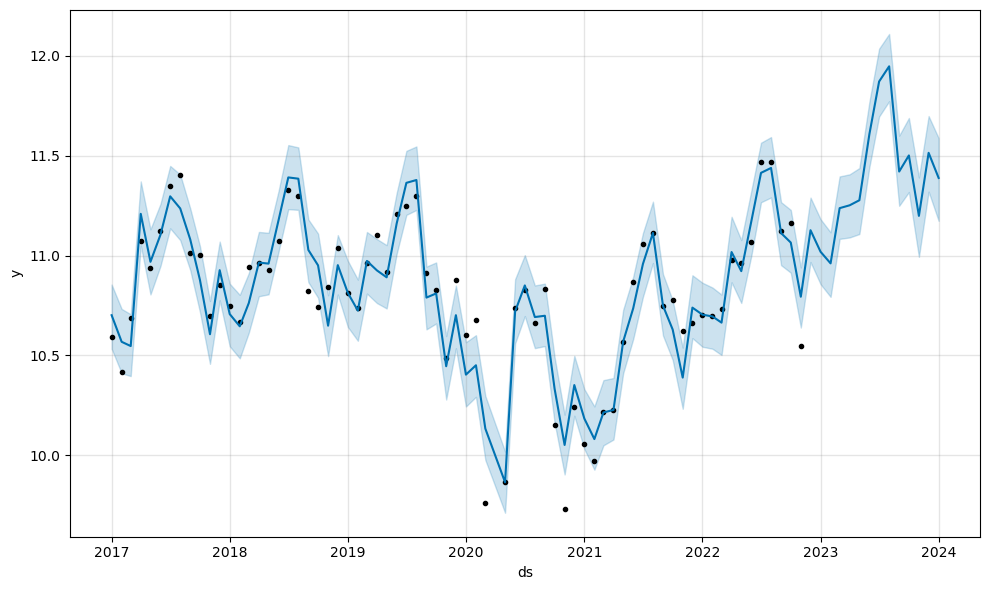

In [98]:
modelo2.plot(prevision3);

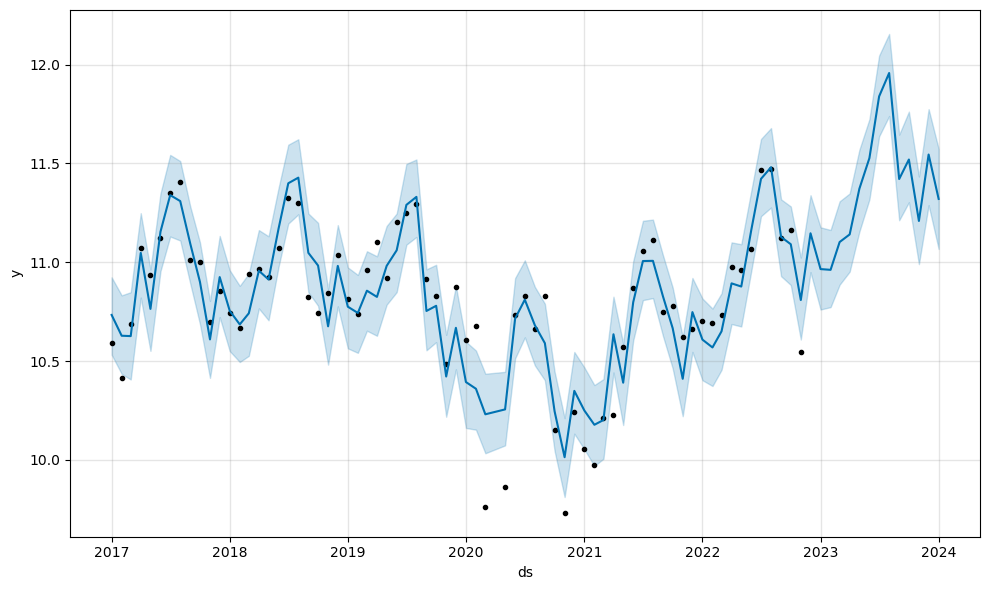

In [99]:
# Modelo anterior
modelo.plot(prevision2);

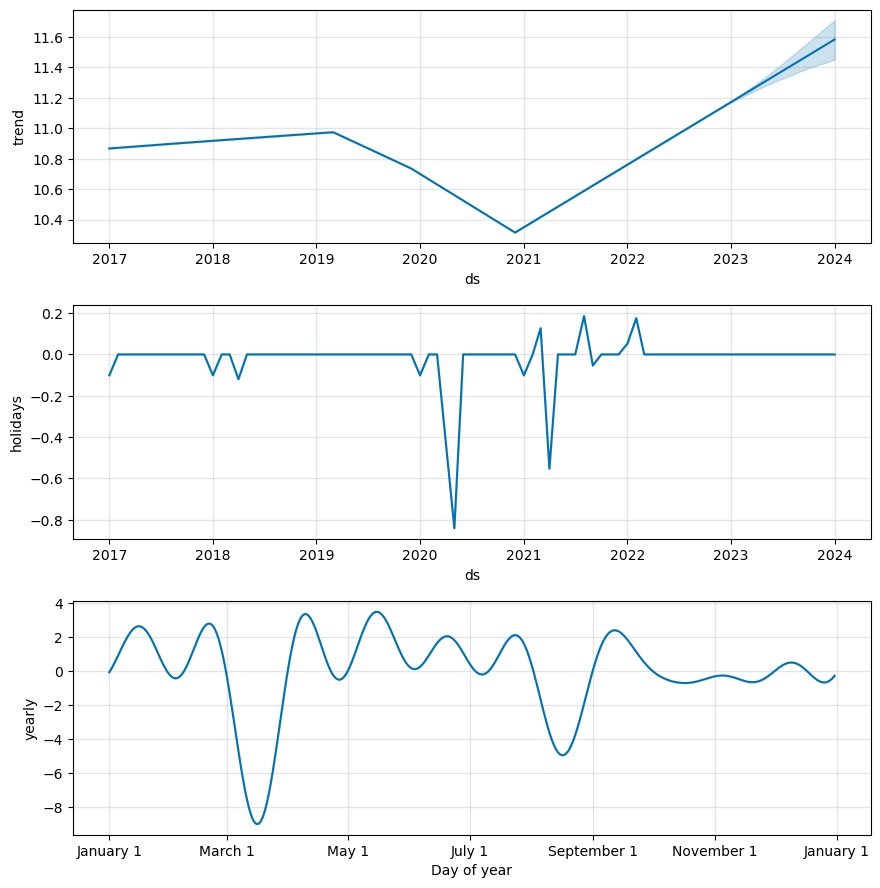

In [100]:
modelo2.plot_components(prevision3, weekly_start=1);

In [101]:
# Ahora añadiremos los eventos futuros
semana_santa = pd.DataFrame({
    'holiday': 'semana_santa',
    'ds': pd.to_datetime([
                        '2017-04-9','2017-04-10','2017-04-11','2017-04-12','2017-04-13','2017-04-14','2017-04-15','2017-04-16',
                        '2018-03-25','2018-03-26','2018-03-27','2018-03-28','2018-03-29','2018-03-30','2018-03-31','2018-04-1',
                        '2019-04-14','2019-04-15','2019-04-16','2019-04-17','2019-04-18','2019-04-19','2019-04-20','2019-04-21',
                        '2020-04-5','2020-04-6','2020-04-7','2020-04-8','2020-04-9','2020-04-10','2020-04-11','2020-04-12',                                                    
                        '2021-03-28','2021-03-29','2021-03-30','2021-03-31','2021-04-1','2021-04-2','2021-04-3','2021-04-4',                                                   
                        '2022-04-10','2022-04-11','2022-04-12','2022-04-13','2022-04-14','2022-04-15','2022-04-16','2022-04-17',
                        '2023-04-2','2023-04-3','2023-04-4','2023-04-5','2023-04-6','2023-04-7','2023-04-8','2023-04-9']),
    'lower_window': 0,
    'upper_window': 0,
})

In [102]:
navidad = pd.DataFrame({
    'holiday': 'navidad',
    'ds': pd.to_datetime([
                        '2016-12-24','2016-12-25','2016-12-26',
                        '2017-12-24','2017-12-25','2017-12-26',
                        '2018-12-24','2018-12-25','2018-12-26',
                        '2018-12-24','2018-12-25','2018-12-26',
                        '2019-12-24','2019-12-25','2019-12-26',
                        '2020-12-24','2020-12-25','2020-12-26',
                        '2021-12-24','2021-12-25','2021-12-26',
                        '2022-12-24','2022-12-25','2022-12-26',
                        '2023-12-24','2023-12-25','2023-12-26']),
    'lower_window': 0,
    'upper_window': 4,
})

In [103]:
fin_de_año = pd.DataFrame({
    'holiday': 'fin de año',
    'ds': pd.to_datetime([
                        '2016-12-31',
                        '2017-12-31',
                        '2019-12-31',
                        '2020-12-31',
                        '2021-12-31',
                        '2022-12-31',
                        '2023-12-31']),
    'lower_window': 0,
    'upper_window': 4,
})

In [104]:
noche_de_reyes = pd.DataFrame({
    'holiday': 'noche de reyes',
    'ds': pd.to_datetime([
                        '2017-1-5',
                        '2018-1-5',
                        '2019-1-5',
                        '2020-1-5',
                        '2021-1-5',
                        '2022-1-5',
                        '2023-1-5']),
    'lower_window': 0,
    'upper_window': 1,
})

In [105]:
carnaval = pd.DataFrame({
    'holiday': 'carnaval',
    'ds': pd.to_datetime([
                        '2017-2-25',
                        '2018-2-10',
                        '2019-3-2',
                        '2020-2-18',
                        '2021-2-13',
                        '2022-2-26',
                        '2023-2-18']),
    'lower_window': 0,
    'upper_window': 0,
})

In [106]:
dia_del_trabajador = pd.DataFrame({
    'holiday': 'dia_del_trabajador',
    'ds': pd.to_datetime([
                        '2017-5-1',
                        '2018-5-1',
                        '2019-5-1',
                        '2020-5-1',
                        '2021-5-1',
                        '2022-5-1',
                        '2023-5-1']),
    'lower_window': 0,
    'upper_window': 0,
})

In [107]:
san_juan = pd.DataFrame({
    'holiday': 'san_juan',
    'ds': pd.to_datetime([
                        '2017-6-23',
                        '2018-6-23',
                        '2019-6-23',
                        '2020-6-23',
                        '2021-6-23',
                        '2022-6-23',
                        '2023-6-23']),
    'lower_window': 0,
    'upper_window': 1,
})

In [108]:
san_pedro = pd.DataFrame({
    'holiday': 'san_pedro',
    'ds': pd.to_datetime([
                        '2017-6-29',
                        '2018-6-29',
                        '2019-6-29',
                        '2020-6-29',
                        '2021-6-29',
                        '2022-6-29',
                        '2023-6-29']),
    'lower_window': 0,
    'upper_window': 0,
})

In [109]:
san_zenon = pd.DataFrame({
    'holiday': 'san_zenon',
    'ds': pd.to_datetime([
                        '2017-7-7','2017-7-8','2017-7-9','2017-7-10',
                        '2018-7-6','2018-7-7','2017-7-8','2017-7-9',
                        '2019-7-5','2019-7-6','2019-7-7','2019-7-8','2019-7-9',
                        '2020-7-8','2020-7-9','2020-7-10','2020-7-11','2020-7-12',
                        '2021-7-8','2021-7-9','2021-7-10','2021-7-11',
                        '2022-7-8','2019-7-9','2019-7-10','2019-7-11',
                        '2023-7-7','2023-7-8','2023-7-9','2023-7-10']),
    'lower_window': 0,
    'upper_window': 0,
})

In [110]:
san_roque = pd.DataFrame({
    'holiday': 'san_roque',
    'ds': pd.to_datetime([
                        '2017-8-14','2017-8-15','2017-8-16',
                        '2018-8-14','2018-8-15','2018-8-16',
                        '2019-8-14','2019-8-15','2019-8-16','2019-8-17',
                        '2020-8-14','2020-8-15','2020-8-16',
                        '2021-8-14','2021-8-15','2021-8-16',
                        '2022-8-12','2022-8-13','2022-8-14','2022-8-15','2022-8-16',
                        '2023-8-14','2023-8-15','2023-8-16']),
    'lower_window': 0,
    'upper_window': 0,
})

In [111]:
diada = pd.DataFrame({
    'holiday': 'diada',
    'ds': pd.to_datetime([
                        '2017-9-11',
                        '2018-9-11',
                        '2019-9-11',
                        '2020-9-11',
                        '2021-9-11',
                        '2022-9-11',
                        '2023-9-11']),
    'lower_window': 0,
    'upper_window': 0,
})

In [112]:
hispanidad = pd.DataFrame({
    'holiday': 'hispanidad',
    'ds': pd.to_datetime([
                        '2017-10-12',
                        '2018-10-12',
                        '2019-10-12',
                        '2020-10-12',
                        '2021-10-12',
                        '2022-10-12',
                        '2023-10-12']),
    'lower_window': -1,
    'upper_window': 1,
})

In [113]:
castañada = pd.DataFrame({
    'holiday': 'castañada',
    'ds': pd.to_datetime([
                        '2017-10-31',
                        '2018-10-31',
                        '2019-10-31',
                        '2020-10-31',
                        '2021-10-31',
                        '2022-10-31',
                        '2023-12-31']),
    'lower_window': 0,
    'upper_window': 1,
})

In [114]:
estado_alarma = pd.DataFrame({
    'holiday': 'estado_alarma',
    'ds': pd.to_datetime(['2020-03-15', '2021-02-07', '2021-07-20','2021-12-22']),
    'lower_window': -5,
    'upper_window': 60,
})

In [115]:
puente_dic = pd.DataFrame({
    'holiday': 'puente_dic',
    'ds': pd.to_datetime([
                        '2017-12-06','2017-12-07',
                        '2018-12-06','2018-12-07',
                        '2019-12-06','2019-12-07',
                        '2020-12-06','2020-12-07',
                        '2021-12-06','2021-12-07',
                        '2022-12-06','2022-12-07',
                        '2023-12-06', '2022-12-07']),
    'lower_window': -3,
    'upper_window': 0,
})

In [116]:
eventos = pd.concat((semana_santa, navidad, san_zenon, san_roque,estado_alarma, fin_de_año, noche_de_reyes, puente_dic))
eventos = eventos.reset_index()

In [117]:
modelo3 = Prophet(holidays=eventos)
prevision4 = modelo3.fit(df_prophet).predict(futuro2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -352.373
Iteration  1. Log joint probability =    110.503. Improved by 462.876.
Iteration  2. Log joint probability =    162.745. Improved by 52.2418.
Iteration  3. Log joint probability =    192.685. Improved by 29.9403.
Iteration  4. Log joint probability =    216.187. Improved by 23.5019.
Iteration  5. Log joint probability =    233.966. Improved by 17.7788.
Iteration  6. Log joint probability =    234.018. Improved by 0.0519558.
Iteration  7. Log joint probability =    234.093. Improved by 0.0749041.
Iteration  8. Log joint probability =    234.093. Improved by 0.0002065.
Iteration  9. Log joint probability =    234.195. Improved by 0.102735.
Iteration 10. Log joint probability =    235.204. Improved by 1.00852.
Iteration 11. Log joint probability =    236.472. Improved by 1.2677.
Iteration 12. Log joint probability =    236.659. Improved by 0.187205.
Iteration 13. Log joint probability =    237.232. Improved by 0.572724.
Iteration 14. Log joint pro

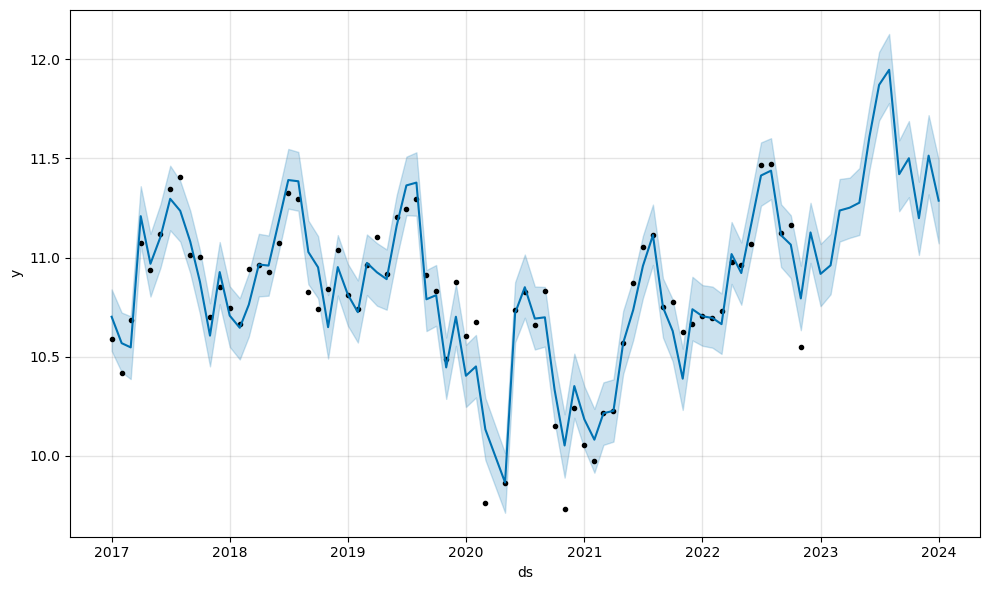

In [118]:
#En este módelo en los mismos holidays añadidos en el módelo anterior le aplicamos las fechas futuras, las que queremos prever.
modelo3.plot(prevision4);

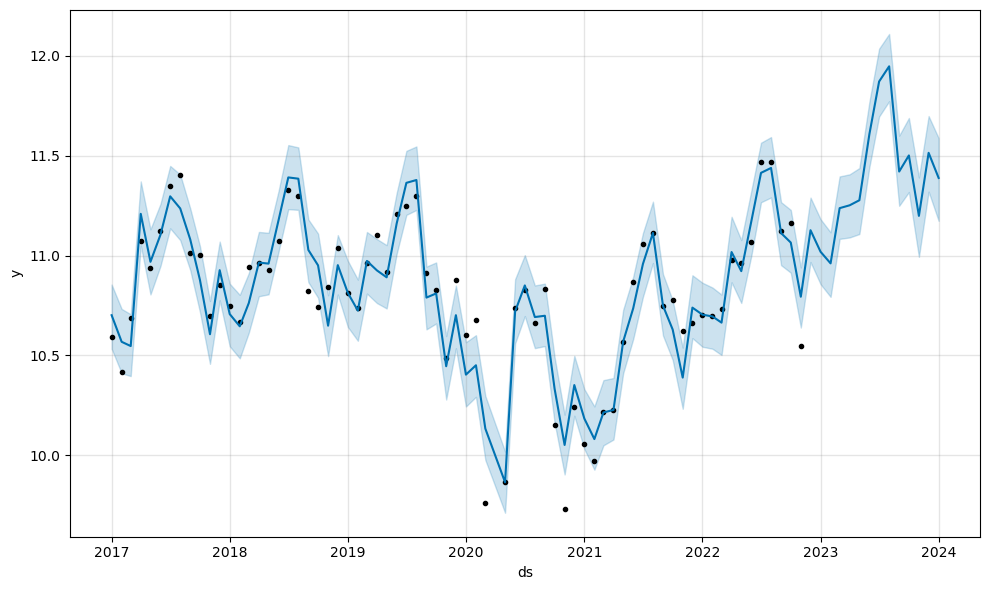

In [119]:
# Segundo modelo
modelo2.plot(prevision3);

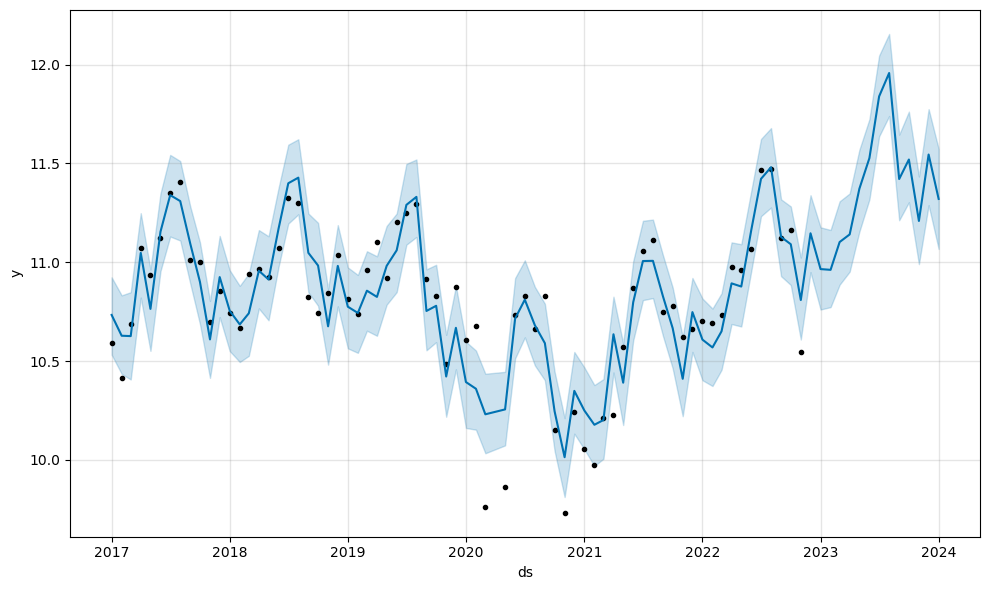

In [120]:
# Primer modelo
modelo.plot(prevision2);

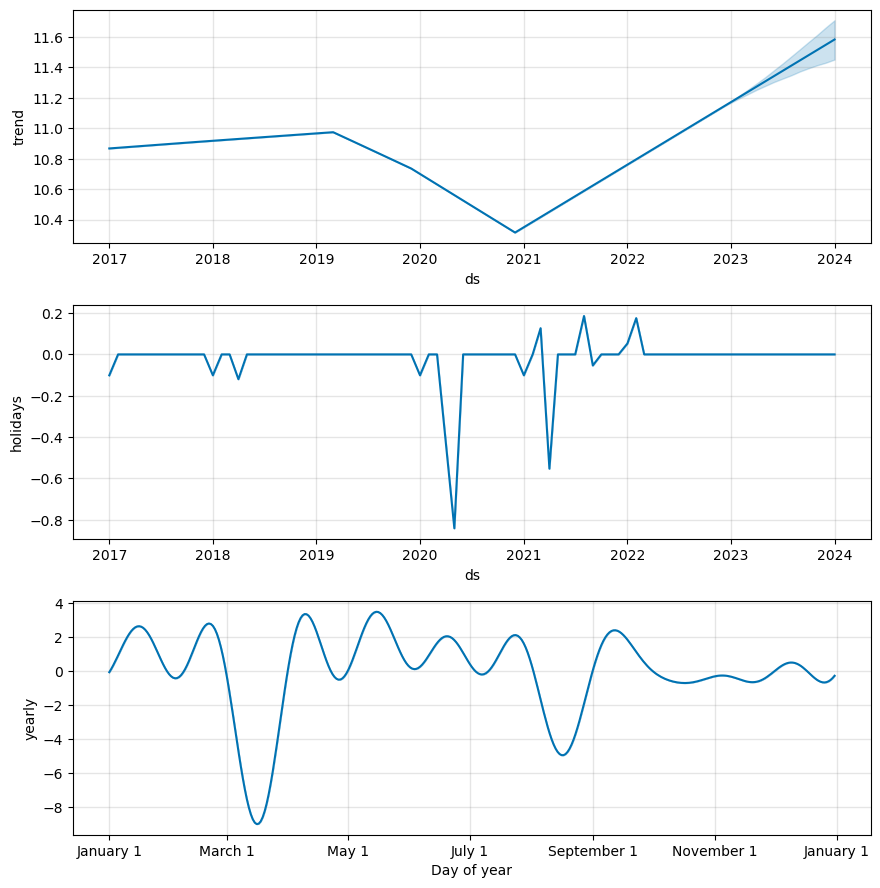

In [121]:
modelo3.plot_components(prevision3, weekly_start = 1);